# Recursive Retrieval on a Lexical Graph 

## Setup
- Create a venv if desired
  - `python3 -m venv venv`
  - `source venv/bin/activate`
- Run `pip install -r requirements.txt` to install the necessary packages.

## Important
- If you are providing a workspace, it should be empty and should only contain documents used build the lexical graph.

## Integration with Reducto

- As of the notebook's creation date, any developers interested in the Reducto API must reach out to founders to get a key for the demo. 
- However, the [free demo on the website](https://app.reducto.ai/) allows up to 10 pages of text to be analyzed
- The API response JSONs can be copied and saved as `<pdf filename without extension>.json` under `docs_structure/reducto/`. 



![Reducto Page](./img/reducto_page.png)
![Reducto Save JSON](./img/reducto_save_json.png)

- In our example, `bnm_compliance.pdf` in `/docs` was saved as `bnm_compliance.json` in `/docs_structure/reducto/`.
- This already has been done for you so you can run the notebook as-is – follow the steps above if you want to try with your own documents.

## Link Detection
<!-- <img src="./img/diagram.png" width="700px"> -->
![Diagram](./img/diagram.png)



- We use pymupdf to extract links from the documents.
- Pymupdf lets us access the locations of the links and the destination of the links (this applies to internal links that link to other parts of the document)
- We locate one Reducto element that is closest to the link's location, and another element closest to the link's destination, and establish a link between the two Reducto elements.
- This is what happens in the `extract_links_and_sections_to_elements` function.
- The output is a dataframe to visualize the links in the pdf


In [1]:
import fitz
import pandas as pd
import numpy as np
import os
import math
import json
from collections import defaultdict
import hashlib
from typing import Dict, Any
FILENAME = "bnm_compliance"

# Unstructured didn't need this, but Reducto needed a vertical stretch to get accurate results
HEIGHT_ADJUSTMENT_FACTOR = 0.96


def calculate_distance(
    point1: tuple[float, float], point2: tuple[float, float]
) -> float:
    """Calculate the Euclidean distance between two points where a point is a two-item tuple for xy coords."""
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


def point_to_segment_distance(
    px: float, py: float, ax: float, ay: float, bx: float, by: float
) -> float:
    """Calculate the minimum distance from point (px, py) to the segment (ax, ay) - (bx, by)."""
    dx, dy = bx - ax, by - ay
    if dx == dy == 0:  # the segment is a point
        return calculate_distance((px, py), (ax, ay))

    t = max(0, min(1, ((px - ax) * dx + (py - ay) * dy) / (dx * dx + dy * dy)))
    nearest = (ax + t * dx, ay + t * dy)
    return calculate_distance((px, py), nearest)


def min_distance_to_bbox(
    point: tuple[float, float], element_bbox_data: dict, pdf_path: str
) -> float:
    """Calculate the minimum distance from a point to a 4-point bounding box."""

    # Normalise pymupdf point to pymupdf's page resolution
    pymupdf_width, pymupdf_height = get_page_resolution_pymupdf(
        pdf_path, element_bbox_data["page"]
    )
    px, py = point
    px /= pymupdf_width
    py /= pymupdf_height

    # Normalise bbox points to Reducto's page resolution
    left, top, width, height = (
        element_bbox_data["left"],
        element_bbox_data["top"],
        element_bbox_data["width"],
        element_bbox_data["height"],
    )
    points = [
        (left, top),
        (left + width, top),
        (left + width, top + height),
        (left, top + height),
    ]
    bbox = [(x, y * HEIGHT_ADJUSTMENT_FACTOR) for x, y in points]

    distances = []

    # Calculate all combinations of point-to-segment distances
    for i in range(len(bbox)):
        ax, ay = bbox[i]
        bx, by = bbox[(i + 1) % len(bbox)]
        distances.append(point_to_segment_distance(px, py, ax, ay, bx, by))
    return min(distances)


def return_closest_elements(
    page_number: int,
    point: tuple[float, float],
    elements_by_pages: defaultdict,
    pdf_path: str,
) -> list:
    """
    Given pymupdf point coordinates and a page number, return a list of Reducto elements on the same
    page sorted by distance to the point. Used to find the corresponding Reducto element to a PDF link
    destination.
    """
    elements = elements_by_pages[page_number]
    sorted_elements = sorted(
        elements,
        key=lambda element: min_distance_to_bbox(point, element["bbox"], pdf_path),
    )
    return sorted_elements


def get_elements_sort_by_pages(file_name: str) -> defaultdict:
    """Retrieve and organise elements by pages from a Reducto output JSON file."""
    elements_file = os.path.join("./docs_structure", "reducto", f"{file_name}.json")

    with open(elements_file, "r") as f:
        data = json.load(f)

    elements_by_pages = defaultdict(list)

    for chunk in data["result"]["chunks"]:
        for element in chunk["blocks"]:
            elements_by_pages[element["bbox"]["page"]].append(element)

    return elements_by_pages


def get_elements(file_name: str) -> Dict[str, Any]:
    """Retrieve elements from a Reducto output JSON file."""
    elements_file = os.path.join("./docs_structure", "reducto", f"{file_name}.json")
    elements = {}

    with open(elements_file, "r") as f:
        data = json.load(f)

        for chunk in data["result"]["chunks"]:
            for element in chunk["blocks"]:
                page_number = int(element["bbox"]["page"])
                element_id = hash_element(element)
                elements[element_id] = element

    return elements


def get_page_resolution_pymupdf(pdf_path: str, page_number: int) -> tuple[float, float]:
    """Get the width and height of a specific page in a PDF document using pymupdf."""
    pdf_document = fitz.open(pdf_path)

    # Ensure the page number is valid
    if page_number < 1 or page_number > pdf_document.page_count:
        raise ValueError("Page number is out of range.")

    # Load the specified page (page_number is 1-based index)
    page = pdf_document.load_page(page_number - 1)

    # Get the page dimensions in points
    width = page.rect.width
    height = page.rect.height

    return width, height


def hash_element(element: dict) -> str:
    """Generate a hash for an element using its content and bounding box."""
    content = element["content"]
    bbox = str(element["bbox"]).encode("utf-8")
    return hashlib.md5(content.encode("utf-8") + bbox).hexdigest()

def whyhow_unique_node_name(content, current_element_hash_id):
    """Generate a unique node name for WhyHow based on the content and element hash."""
    clean_content = ' '.join(content.split())
    node_name_content_preview = clean_content[:50] + "..." if len(clean_content) > 50 else clean_content
    # node name has to be unique on whyhow systems, so add element hash/id to the end to make it unique
    node_name_content_preview += "_"
    node_name_content_preview += current_element_hash_id
    return node_name_content_preview

def extract_links_and_sections_to_elements(
    pdf_path: str, elements_by_pages: defaultdict
) -> tuple[pd.DataFrame, list[tuple]]:
    """
    Extract links from a PDF document and associate them with Reducto elements based on proximity.

    Returns a DataFrame containing the link information and a list of tuples representing links
    between elements.
    """
    document = fitz.open(pdf_path)
    links_data = []
    links_tuples = []

    for page_num in range(len(document)):
        page = document.load_page(page_num)
        links = page.get_links()

        for link in links:
            link_data = {}
            link_data["page_number"] = page_num + 1

            # Extract link text
            rect = fitz.Rect(link["from"])
            text = page.get_text("text", clip=rect)
            link_data["link_text"] = text.strip() if text else "No text"

            x, y, _, _ = link["from"]  # Get the coordinates of the link
            closest_elems = return_closest_elements(
                page_num + 1, (x, y), elements_by_pages, pdf_path
            )
            closest_elem = closest_elems[0] if closest_elems else None
            if closest_elem:
                link_data["guess_link_reducto_element"] = closest_elem["content"]
                link_element_id = hash_element(closest_elem)
            else:
                link_data["guess_link_reducto_element"] = "N/A"
                link_element_id = None

            # Determine link type and location
            if link["kind"] == fitz.LINK_GOTO:
                link_data["link_type"] = "internal"
                link_data["link_destination"] = "page " + str(
                    link["page"] + 1 if link["page"] >= 0 else "Unknown"
                )

                # Extract named destination if available
                dest = link.get("to", None)
                if dest:
                    link_data["named_destination"] = f"Coordinates: {dest}"
                    x, y = dest
                    target_page_num = link["page"] + 1
                    closest_elems = return_closest_elements(
                        target_page_num, (x, y), elements_by_pages, pdf_path
                    )
                    closest_elem = closest_elems[0] if closest_elems else None
                    if closest_elem:
                        link_data["guess_destination_reducto_element"] = closest_elem[
                            "content"
                        ]
                        link_destination_element_id = hash_element(closest_elem)
                    else:
                        link_data["guess_destination_reducto_element"] = "N/A"
                        link_destination_element_id = None
                else:
                    link_data["named_destination"] = "N/A"
                    link_data["guess_destination_reducto_element"] = "N/A"
                    link_destination_element_id = None

            elif link["kind"] == fitz.LINK_URI:
                link_data["link_type"] = "external"
                link_data["link_destination"] = link["uri"]
                link_data["named_destination"] = "N/A"
                link_data["guess_destination_reducto_element"] = "N/A"
                link_destination_element_id = link["uri"]
            else:
                link_data["link_type"] = "unknown"
                link_data["link_destination"] = "Unknown location"
                link_data["named_destination"] = "N/A"
                link_data["guess_destination_reducto_element"] = "N/A"
                link_destination_element_id = None

            # Keep track of tuples to create links later in Neo4j
            links_tuples.append((link_element_id, link_destination_element_id))
            links_data.append(link_data)

    df = pd.DataFrame(links_data)

    # Replace NaN and infinite values
    df.replace([np.inf, -np.inf, np.nan], "N/A", inplace=True)

    return df, links_tuples


def save_to_csv(df: pd.DataFrame, output_path: str) -> None:
    """Save a DataFrame to a CSV file at the specified path."""
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df.to_csv(output_path, index=False)


def analyse_links(
    filename: str, elements_by_pages: defaultdict
) -> tuple[pd.DataFrame, list[tuple]]:
    """
    Analyse links in a PDF document, matching them to Reducto elements, and saving the results to a CSV file.

    Returns a DataFrame with the link data and a list of tuples representing links between elements.
    """
    # Path to your PDF file
    pdf_path = f"docs/{filename}.pdf"

    # Extract links to df
    links_df, links_tuples = extract_links_and_sections_to_elements(
        pdf_path, elements_by_pages
    )
    print("Links tuples: ", links_tuples)

    # Save DataFrame to CSV
    output_csv_path = f"docs_links/{filename}-with-reducto.csv"
    save_to_csv(links_df, output_csv_path)

    return links_df, links_tuples


# Example usage
links_df, explicit_links = analyse_links(
    FILENAME, get_elements_sort_by_pages(FILENAME)
)
links_df.head(200)

Links tuples:  [('f5f9f96d5d805f4e7d1ce832cc0e4937', '5feb986fe20fb5de66a9d110a602f280'), ('2cd1bcffc9bbdd0e7e590bfb22c52c1f', '1ce9f6267c7404bc6f29825b40c66c77'), ('c21822c0338a1563d5e8100467df1bc2', '1cc747588ddb4be5060534dd2d53eaba'), ('fabbe7be4a8a55626bc1d90782d54852', 'a878a69b7a0e10e0b5dd1f3c02c82049'), ('552896ac6f1046fe4f601afcdf5c6325', 'c097483e4d870f1651a3fbbf31e1f380'), ('42c2c25fccac1b063f84600d5807f3ff', 'da2a46ebf01d7a06d709c6c2fb8a0bda'), ('b432259b7584d0d856d4e444985de1c2', '499dcdb601259bb3cbce85ce364ed632'), ('2c517489527da348b5fc153b17b87057', '91f5ccdce7837fc5c8ab0b3ed7e14e54'), ('003d2a95aa3e44c56b28ca467f614446', '6cdf24899c11cedfa54a1f48658033a1'), ('39415dc21008fef7877cde99174cae62', '9898aabafc24b8c858516d18f8ca38fc'), ('baa81dc508fb8531ce35ede2c2246829', '0c30c80e8079513bcfb42217d016f720'), ('1cc747588ddb4be5060534dd2d53eaba', 'e4308cee3126ddd2a949650aeb69a368'), ('bbba75c05798bba059a8269b624befcb', '63f9a7375e9087b9974612325f288586'), ('bbba75c05798bba059a8

,page_number,link_text,guess_link_reducto_element,link_type,link_destination,named_destination,guess_destination_reducto_element
0,2,PART A OVERVIEW \n..........................,PART A OVERVIEW,internal,page 3,"Coordinates: Point(68.0, 83.91998)",PART A OVERVIEW
1,2,1 \nIntroduction ................................,1 Introduction,internal,page 3,"Coordinates: Point(68.0, 112.91998)",1 Introduction
2,2,2 \nApplicability ...............................,2 Applicability,internal,page 3,"Coordinates: Point(68.0, 671.92)",2.1 This policy document is applicable to all ...
3,2,3 \nLegal provisions ............................,3 Legal provisions,internal,page 4,"Coordinates: Point(68.0, 83.91998)",3 Legal provisions
4,2,4 \nEffective date ..............................,4 Effective date,internal,page 4,"Coordinates: Point(68.0, 229.91999)",4 Effective date
5,2,5 \nInterpretation ..............................,5 Interpretation,internal,page 4,"Coordinates: Point(68.0, 291.91999)",5 Interpretation
6,2,PART B POLICY REQUIREMENTS \n...............,PART B POLICY REQUIREMENTS,internal,page 6,"Coordinates: Point(68.0, 83.91998)",PART B POLICY REQUIREMENTS
7,2,6 \nResponsibilities of the board and senior m...,6 Responsibilities of the board and senior man...,internal,page 6,"Coordinates: Point(68.0, 112.91998)",6 Responsibilities of the board and senior man...
8,2,7 \nOrganisation of the compliance function .....,7 Organisation of the compliance function,internal,page 8,"Coordinates: Point(68.0, 345.91999)",\t- 7 Organisation of the compliance function
9,2,8 \nResponsibilities of the compliance functio...,8 Responsibilities of the compliance function,internal,page 10,"Coordinates: Point(68.0, 441.91999)",\t- 8 Responsibilities of the compliance function


# Building the Definitions Graph with WhyHow

## Setup WhyHow Workspace


In [2]:
from typing import List, Tuple, Dict, Any, Optional
import csv
from whyhow.schemas import Triple, Node, Relation, Chunk, Document, Workspace, Schema
from whyhow import WhyHow
import sys
import os
from dotenv import load_dotenv



load_dotenv()

WHYHOW_API_KEY = os.getenv("WHYHOW_API_KEY")
WHYHOW_API_URL = os.getenv("WHYHOW_API_URL")


def fetch_or_create_new_workspace(
    workspace_name: str, client: Optional[WhyHow] = None
) -> Workspace:
    """
    Fetches an existing workspace by name or creates a new one if none exists.
    """
    # SDK only supports getting workspace by ID, since one can create workspaces with duplicate names
    # We assume for convenience that the workspace name is unique so we can fetch workspace by name over and over again

    # Don't have to keep creating new workspaces every time cells are run
    if client is None:
        client = WhyHow(api_key=WHYHOW_API_KEY, base_url=WHYHOW_API_URL)

    print("FETCH/CREATE WORKSPACE: Looking for workspaces:")
    workspaces = client.workspaces.get_all(limit=20, name=workspace_name)

    # return the first instance of the workspace with the same name
    for workspace in workspaces:
        if workspace.name == workspace_name:
            print(
                f"FETCH/CREATE WORKSPACE: Found workspace with matching name {workspace_name} id={workspace.workspace_id}."
            )
            return workspace
    print(
        f"FETCH/CREATE WORKSPACE: No workspace found with name {workspace_name}. Creating new workspace..."
    )
    return client.workspaces.create(workspace_name)


WORKSPACE_ID = fetch_or_create_new_workspace("Central Bank Compliance").workspace_id
FILENAME = "bnm_compliance"


def update_schema(schema_dir: str, client: Optional[WhyHow] = None) -> Schema:
    """
    Updates a schema on WhyHow by uploading a new schema file. If a schema with the same name exists, it is deleted.
    """
    # Convention: only one schema should exist on WhyHow for every schema file here.
    # Otherwise, constantly running this cell will create duplicate, messy schemas.

    if client is None:
        client = WhyHow(api_key=WHYHOW_API_KEY, base_url=WHYHOW_API_URL)
    # check that schema_dir points to a file that exists
    if not os.path.isfile(schema_dir):
        raise FileNotFoundError(f"Schema file {schema_dir} not found.")

    print("UPDATE SCHEMA: Checking for existing schemas with same name...")
    schema_name = os.path.basename(schema_dir)

    # Delete all schemas of the same name.
    workspace_schemas = client.schemas.get_all(workspace_id=WORKSPACE_ID)
    if not workspace_schemas:
        matched_schemas = [
            schema for schema in workspace_schemas if schema.name == schema_name
        ]

        if matched_schemas:
            print(
                f"UPDATE SCHEMA: Found {len(matched_schemas)} existing schema(s) with same name. Deleting..."
            )
            for schema in matched_schemas:
                client.schemas.delete(schema.schema_id)

    print(f"UPDATE SCHEMA: Updating schema from {schema_dir}...")
    entities, relations, patterns = client.schemas.load_json(schema_dir)
    new_schema = client.schemas.create(
        workspace_id=WORKSPACE_ID,
        name=schema_name,
        entities=entities,
        relations=relations,
        patterns=patterns,
    )
    print(
        f"UPDATE SCHEMA: Uploaded schema {schema_name} with ID: {new_schema.schema_id}\n"
    )
    return new_schema


import shutil


def update_document(document_dir: str, client: Optional[WhyHow] = None) -> Document:
    """
    Updates a document on WhyHow by uploading a new document file. If a document with the same name exists, it is deleted.
    """
    if client is None:
        client = WhyHow(api_key=WHYHOW_API_KEY, base_url=WHYHOW_API_URL)
    # Convention: only one document should exist on WhyHow for every document file here.
    # Otherwise, constantly running this cell will create duplicate, messy documents.

    # check that document_dir points to a file that exists
    if not os.path.isfile(document_dir):
        raise FileNotFoundError(f"Document file {document_dir} not found.")

    document_name = os.path.basename(document_dir)

    existing_docs = list(
        client.documents.get_all(workspace_id=WORKSPACE_ID, filename=document_name)
    )
    if existing_docs:
        print("UPDATE DOC: Found old existing document in workspace. Deleting...")
        _ = client.documents.delete(existing_docs[0].document_id)
    else:
        print(f"UPDATE DOC: No old existing document found in workspace.")

    print(f"UPDATE DOC: Creating new document {document_name} in workspace...")
    try:
        document = client.documents.upload(path=document_dir, workspace_id=WORKSPACE_ID)
        return document
    except Exception as e:
        print(
            f"UPDATE DOC: Failed to upload document: renaming... {document_name}. {e}"
        )
        # get local doc and make a copy with a number at the end:
        base_name, ext = os.path.splitext(document_name)
        new_document_name = f"{base_name}_1{ext}"
        new_document_dir = os.path.join(
            os.path.dirname(document_dir), new_document_name
        )

        # copy the local doc to the new name
        shutil.copy(document_dir, new_document_dir)

        print(f"UPDATE DOC: Retrying with new document name {new_document_name}...")
        try:
            document = client.documents.upload(
                path=new_document_dir, workspace_id=WORKSPACE_ID
            )
            return document
        except Exception as e:
            print(
                f"UPDATE DOC: Failed to upload document again: {new_document_name}. {e}"
            )
            raise


def retrieve_document(document_name, client=None):
    """
    Retrieves a document by name from the WhyHow workspace.
    """
    if client is None:
        client = WhyHow(api_key=WHYHOW_API_KEY, base_url=WHYHOW_API_URL)

    print(f"RETRIEVE DOC: Fetching document {document_name} from workspace...")
    documents = list(
        client.documents.get_all(
            limit=20, filename=document_name, workspace_id=WORKSPACE_ID
        )
    )
    if not documents:
        raise FileNotFoundError(
            f"RETRIEVE DOC:  Failed to find existing document by filename."
        )
    else:
        print(
            f"RETRIEVE DOC: Found document in workspace. Fetching first instance with id {documents[0].document_id}"
        )
        return documents[0]


LEXICAL_SCHEMA_NAME = "Lexical Graph Schema"
LEXICAL_SCHEMA_DIR = os.path.join("schema", "lexical_schema.json")
DEFINITIONS_SCHEMA_NAME = "Definition Graph Schema"
DEFINITIONS_SCHEMA_DIR = os.path.join("schema", "definitions_schema.json")
LEXICAL_SCHEMA_ID = update_schema(LEXICAL_SCHEMA_DIR).schema_id

DEFINITIONS_SCHEMA_ID = update_schema(DEFINITIONS_SCHEMA_DIR).schema_id


FETCH/CREATE WORKSPACE: Looking for workspaces:
FETCH/CREATE WORKSPACE: Found workspace with matching name BNM Compliance Test id=66d7fd24779a727e458a5945.
UPDATE SCHEMA: Checking for existing schemas with same name...
UPDATE SCHEMA: Updating schema from schema/lexical_schema.json...
UPDATE SCHEMA: Uploaded schema lexical_schema.json with ID: 66d822bceda622fc957cc7fe

UPDATE SCHEMA: Checking for existing schemas with same name...
UPDATE SCHEMA: Updating schema from schema/definitions_schema.json...
UPDATE SCHEMA: Uploaded schema definitions_schema.json with ID: 66d822bd779a727e458a5aba



## Building the definition Graph on WhyHow


In [3]:
import os
import fitz  # PyMuPDF
import csv
from pydantic import BaseModel
from openai import OpenAI
from dotenv import load_dotenv
from typing import Tuple, List

from whyhow import WhyHow
from whyhow.schemas import Triple, Node, Relation, Chunk, Graph


# Load environment variables
load_dotenv()

# Get OpenAI API key from environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")
if openai_api_key is None:
    raise ValueError("OPENAI_API_KEY not found in environment variables.")

# Initialize OpenAI client
openai_client = OpenAI()
openai_client.api_key = openai_api_key


class TermDefinition(BaseModel):
    """
    Pydantic schema used to describe the structured output of legal term-definition pairs for the GPT-4o model.
    """

    term: str
    definition: str


class TermDefinitionCSV(BaseModel):
    """
    Pydantic schema used to describe the structured output of legal term-definition pairs CSv for GPT-4o
    """

    content: List[TermDefinition]


class DefinitionGraphBuilder(BaseModel):
    """
    Given a range of pages, the builder extracts legal terms and their definitions from a PDF.
    This PDF is found using the global FILENAME.
    The builder can save extracted terms as a CSV file, and upload to WhyHow.

    If build_csv is False, no new CSV is created, only the existing one is uploaded.
    """

    # page range starts count from 1
    definitions_page_ranges: List[Tuple[int, int]]
    file_path: str = f"./docs/{FILENAME}.pdf"
    definitions_csv_path: str = f"./whyhow_csv_chunks/{FILENAME}_definitions.csv"
    definitions_csv_filename: str = os.path.basename(definitions_csv_path)
    schema_dir: str = DEFINITIONS_SCHEMA_DIR

    # if build_csv is False, the builder will not create a new local CSV, it will just upload the existing one
    build_csv: bool = True
    graph_name: str = "Legal Definitions Graph"
    graph: Optional[Graph] = None

    def extract_and_save_to_csv(self):
        doc = fitz.open(self.file_path)

        all_terms_and_definitions = []

        # Flatten the list of ranges into individual pages
        page_numbers = []
        for start, end in self.definitions_page_ranges:
            page_numbers.extend(range(start, end + 1))

        for page_num in page_numbers:
            page = doc.load_page(page_num - 1)  # subtract 1 for 0-based index
            text = page.get_text("text")

            prompt = f"""
You will be shown a text from a page of a document containing legal terms and their definitions. Your task is to extract the legal terms and their corresponding definitions (verbatim) from the text and return them as the schema JSON.

Text:
{text}

Provide the extracted terms and definitions in the specified CSV format.
"""
            completion = openai_client.beta.chat.completions.parse(
                model="gpt-4o-2024-08-06",
                messages=[
                    {"role": "system", "content": "Extract the terms and definitions."},
                    {"role": "user", "content": prompt},
                ],
                response_format=TermDefinitionCSV,
            )

            terms_and_definitions = completion.choices[0].message.parsed.content
            print(f"page {page_num}: {terms_and_definitions}")

            # Ensure that terms_and_definitions is a list of TermDefinition objects
            if isinstance(terms_and_definitions, list):
                for item in terms_and_definitions:
                    if isinstance(item, TermDefinition):
                        all_terms_and_definitions.append((item.term, item.definition))
                    else:
                        print("Unexpected item format:", item)

        with open(self.definitions_csv_path, "w", newline="") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["Legal Term", "Definition"])
            for term, definition in all_terms_and_definitions:
                writer.writerow([term, definition])

        print(f"Created new CSV file, saved to {self.definitions_csv_path}")

    def build_definitions_graph(self):
        client = WhyHow(api_key=WHYHOW_API_KEY, base_url=WHYHOW_API_URL)
        if self.build_csv:
            self.extract_and_save_to_csv()
            document = update_document(self.definitions_csv_path)
        else:
            document = retrieve_document(self.definitions_csv_filename)

        schema = update_schema(self.schema_dir)

        self.graph = client.graphs.create(
            name="Legal Definitions Graph",
            workspace_id=WORKSPACE_ID,
            document_ids=[document.document_id],
            schema_id=schema.schema_id,
            mode="structured",
        )
        print(f"Created graph with ID: {self.graph.graph_id}")

        return self.graph


definitions_graph = DefinitionGraphBuilder(
    definitions_page_ranges=[(4, 5)],
    file_path=f"./docs/{FILENAME}.pdf",
    definitions_csv_path=f"./whyhow_csv_chunks/{FILENAME}_definitions.csv",
    build_csv=True,
    graph_name="Legal Definitions Graph",
).build_definitions_graph()

page 4: [TermDefinition(term='S', definition='denotes a standard, an obligation, a requirement, specification, direction, condition and any interpretative, supplemental and transitional provisions that must be complied with. Non-compliance may result in enforcement action;'), TermDefinition(term='G', definition='denotes guidance which may consist of statements or information intended to promote common understanding and advice or recommendations that are encouraged to be adopted;'), TermDefinition(term='board', definition='means the board of directors of a financial institution, including a committee of the board where the responsibilities of the board set out in this policy document have been delegated to such a committee;'), TermDefinition(term='senior management', definition='refers to the chief executive officer and senior officers of a financial institution;'), TermDefinition(term='chief compliance officer', definition='means the senior officer of a financial institution, however s

# Building the Lexical Graph with WhyHow

- Note: WhyHow only has one identifying field for the node, node_name, and it has to be unique. 
  - Due to this, Node name and id mean the same thing. On the UI, it shows node_name to the user
  - The way we structured this notebook is to use a preview (first 50 characters of element content) + a hash of the reducto element to use as node_name/node_id
  - This makes things a lot more readable on the UI
  - This also has a nice side effect of node_ids also containing a little bit of content/context for LLMs. See more in the "Updating Node Context with Link Info":



In [73]:
from pydantic import BaseModel
from typing import Tuple, List

from whyhow import WhyHow
from whyhow.schemas import Triple, Node, Relation, Chunk, Graph, Workspace
import networkx as nx
from enum import Enum

class ElementType(str, Enum):  # subclass of str so JSON serializable
    PAGE = "Page"
    TITLE = "Title"
    FIGURE = "Figure"
    FOOTER = "Footer"
    LIST_ITEM = "List Item"
    HEADER = "Header"
    DOCUMENT = "Document"
    SECTION_HEADER = "Section Header"
    TEXT = "Text"
    TABLE = "Table"


ELEMENTS = [ElementType.value for ElementType in ElementType]

class WhyHowLexicalGraphBuilder(BaseModel):
    class Config:
        # WhyHow SDK doesn't have validators for WhyHow Client
        arbitrary_types_allowed = True

    file_name: str
    client: Optional[WhyHow] = None
    workspace: Workspace = fetch_or_create_new_workspace("Central Bank Compliance")
    build_and_upload_csvs: bool = True

    json_data: Optional[Dict[str, Any]] = None
    graph: Optional[Graph] = None
    schema_dir: str = LEXICAL_SCHEMA_DIR

    triples: List[Triple] = []

    # Data structures to store Elements
    elements_by_page_number: Optional[Dict[str, List[Dict[str, Any]]]] = None
    elements: Optional[List[Dict[str, Any]]] = None
    # Other data structures to store links and footers
    links_tuples: Optional[List[Tuple[str, str]]] = None
    footers_by_page_number: Optional[Dict[str, List[str]]] = None
    # Init a lookup map that links an element hash id to its corresponding chunk on WhyHow
    hash_lookup_chunk: Dict[str, Chunk] = {}
    # Init a lookup map that links an element hash id to its corresponding node on WhyHow
    hash_lookup_node: Dict[str, Node] = {}
    # Init a map that links a chunk_id to its corresponding chunk
    chunk_map: Dict[str, Chunk] = {}

    def __init__(self, **data):
        super().__init__(**data)
        # Load the JSON data for elements
        print("Loading JSON data...")
        try:
            with open(
                os.path.join("./docs_structure", "reducto", f"{self.file_name}.json"),
                "r",
            ) as f:
                self.json_data = json.load(f)
                print("JSON data loaded.")
            if not self.json_data:
                raise ValueError("No data found in JSON file.")
        except FileNotFoundError:
            raise FileNotFoundError("JSON file not found.")

        # Data structures to store Elements
        self.elements_by_page_number = get_elements_sort_by_pages(self.file_name)
        self.elements = get_elements(self.file_name)
        # Other data structures to store links and footers
        self.links_tuples = analyse_links(self.file_name, self.elements_by_page_number)[
            1
        ]
        self.footers_by_page_number = defaultdict(list)

        if self.client is None:
            self.client = WhyHow(api_key=WHYHOW_API_KEY, base_url=WHYHOW_API_URL)

    def build_csvs(self):
        print("Initialising CSV files...")

        for element_type in ELEMENTS:
            file_name_element = element_type.lower().replace(" ", "_")
            csv_path = os.path.join(
                "./whyhow_csv_chunks", f"{self.file_name}_{file_name_element}.csv"
            )

            with open(csv_path, "w", newline="") as f:
                writer = csv.writer(f)
                if element_type == "Page":
                    writer.writerow(
                        [element_type, "Type", "Hash", "Node Name", "Page Number"]
                    )
                elif element_type == "Document":
                    writer.writerow([element_type, "Type"])
                else:
                    writer.writerow(
                        [
                            element_type,
                            "Type",
                            "Hash",
                            "Node Name",
                            "Content",
                            "Page Number",
                            "Location",
                        ]
                    )

        # write CSVs consisting of elements
        print("Writing elements to CSV files...")
        for reducto_chunk in self.json_data["result"]["chunks"]:
            for element in reducto_chunk["blocks"]:
                type = element["type"]
                page_number = element["bbox"]["page"]
                element_id_hash = hash_element(element)

                # Escape double quotes in content
                content = element["content"].replace('"', '""')
                # for pydantic issues where str cannot be ""
                if content == "":
                    content = "(empty content)"

                node_name = whyhow_unique_node_name(content, element_id_hash)

                if type in ELEMENTS and type not in ["Page", "Document"]:
                    file_name_element = type.lower().replace(" ", "_")
                    csv_path = os.path.join(
                        "./whyhow_csv_chunks",
                        f"{self.file_name}_{file_name_element}.csv",
                    )
                    # Header Row for Figure/Footer/Header/List Item/Section Header/Table/Text/Title CSVs
                    # [element_type, "Type", "Hash", "Node Name", "Content", "Page Number", "Location"]
                    data_row = [
                        element_id_hash,
                        node_name,
                        f'"{content}"',
                        page_number,
                        f'"{element["bbox"]}"',
                    ]
                    with open(csv_path, "a", newline="") as f:
                        writer = csv.writer(f)
                        writer.writerow([f'"{content}"', type] + data_row)

        # Write a single row to represent the document
        document_csv_path = os.path.join(
            "./whyhow_csv_chunks", f"{self.file_name}_document.csv"
        )
        with open(document_csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            # Header row for Document CSV is ["Document", "Type"]
            writer.writerow([self.file_name, "Document"])

        # Write a single row to represent the cover page. Can add on more for other pages e.g. Table of Contents, Appendix.
        # Need to come up with a programmatic way for write_csvs to handle custom pages
        pages_csv_path = os.path.join(
            "./whyhow_csv_chunks", f"{self.file_name}_page.csv"
        )
        # Header row for Pages CSV is ["Page", "Type", "Hash", "Node Name", "Page Number"]
        with open(pages_csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["Cover Page", "Page", "cover_page", "Cover Page", 1])

    def upload_csvs_to_whyhow(self):
        # Add CSV documents to workspace:
        print("Uploading CSV files to WhyHow workspace...")
        for element_type in ELEMENTS:
            element_type = element_type.lower()
            file_name_element = element_type.replace(" ", "_")
            csv_path = os.path.join(
                "./whyhow_csv_chunks", f"{self.file_name}_{file_name_element}.csv"
            )
            doc = update_document(csv_path)

    def update_hash_lookups(self):
        print("Updating hash_chunkid_map...")
        docs = self.client.documents.get_all(workspace_id=self.workspace.workspace_id)
        for doc in docs:
            print(f"Processing document {doc.metadata.filename}")
            chunks = self.client.chunks.get_all(document_filename=doc.metadata.filename)
            skip_doc = False  # Flag to determine if the document should be skipped
            # we retrieve all docs from WhyHow, but only want to process the csvs for document elements

            for chunk in chunks:
                if "Type" not in chunk.content:
                    skip_doc = True  # Set the flag to skip the document
                    print(
                        f"Skipping document {doc.metadata.filename}, it is not an elements csv file. Probably a definitions csv file."
                    )
                    break  # Exit the chunk loop and skip the document

                chunk_type = chunk.content["Type"]
                if chunk_type == "Page":
                    self.hash_lookup_chunk[chunk.content["Hash"]] = chunk
                elif chunk_type == "Document":
                    self.hash_lookup_chunk[self.file_name] = chunk
                else:
                    self.hash_lookup_chunk[chunk.content["Hash"]] = chunk

                # Add chunk to chunk_map
                self.chunk_map[chunk.chunk_id] = chunk

            if skip_doc:
                continue  # Skip processing the rest of this document

    def create_new_node(
        self, element_hash_id, type, node_name_content_preview, properties, chunk_ids=[]
    ):
        # create a new node with SDK
        self.hash_lookup_node[element_hash_id] = Node(
            label=type,
            name=node_name_content_preview,
            chunk_ids=chunk_ids,
            properties=properties,
        )
        print(f"Created new node: {element_hash_id} with type {type}")

    def link_nodes(self, head_hash, tail_hash, relation):
        # link any two nodes, given their hash ids and a relation
        chunk_ids = [
            self.hash_lookup_chunk[head_hash].chunk_id,
            self.hash_lookup_chunk[tail_hash].chunk_id,
        ]

        # for pydantic reasons, we cannot have empty strings in chunk_ids
        if "" in chunk_ids:
            chunk_ids = [id for id in chunk_ids if id != ""]

        self.triples.append(
            Triple(
                head=self.hash_lookup_node[head_hash],
                tail=self.hash_lookup_node[tail_hash],
                relation=relation,
                chunk_ids=chunk_ids,
            )
        )
        print(f"Linked {head_hash} to {tail_hash} with relation {relation.name}")

    def build_graph_whyhow(self):
        # If we already have uploaded the CSVs, we can skip the CSV creation and uploading steps
        # update_hash_lookups updates local map with data from whyhow
        if not self.build_and_upload_csvs:
            self.update_hash_lookups()
        else:
            self.build_csvs()
            self.upload_csvs_to_whyhow()
            self.update_hash_lookups()

        last_section_id = None
        last_list_item_id = None

        # Denotes an element containing another element. Used for collecting indented list items under a single list item
        contains_relation = Relation(name="contains")

        # Denotes a section being a parent of elements .
        is_parent_relation = Relation(name="is_parent")

        # Denotes a link in the pdf, linking from one section/element to another
        links_to_relation = Relation(name="links_to")

        # Used to keep track of section header flows in a document
        follows_relation = Relation(name="follows")

        print("Initialising Triples and Nodes...")
        # create new document
        self.hash_lookup_node[self.file_name] = Node(
            label="Document",
            name=self.file_name,
            properties=self.hash_lookup_chunk[self.file_name].content,
            chunk_ids=[self.hash_lookup_chunk[self.file_name].chunk_id],
        )

        # create cover page
        self.hash_lookup_node["cover_page"] = Node(
            label="Page",
            name="Cover Page",
            properties=self.hash_lookup_chunk["cover_page"].content,
            chunk_ids=[self.hash_lookup_chunk["cover_page"].chunk_id],
        )

        # link cover page to document
        self.link_nodes(self.file_name, "cover_page", contains_relation)

        for reducto_chunk in self.json_data["result"]["chunks"]:
            for element in reducto_chunk["blocks"]:
                page_number = int(element["bbox"]["page"])
                type = element["type"]
                content = element["content"]

                current_element_hash_id = hash_element(element)
                # print("Current element hash id: ", current_element_hash_id)

                # come up with the name for the node on WhyHow
                node_name_content_preview = whyhow_unique_node_name(
                    content, current_element_hash_id
                )
                # print(
                #     f"Processing new {type} element on page {page_number} with content: {node_name_content_preview}"
                # )

                # Assign footers
                if type == "Footer":
                    self.footers_by_page_number[page_number].append(element)

                if type == "Page Number":
                    continue

                if page_number == 1:
                    # create new id for element
                    # self.create_new_element(session, element_id, page_number, content, type)
                    # self.link_element_to_page(session, cover_page_id, element_id, type)
                    try:
                        self.create_new_node(
                            current_element_hash_id,
                            type,
                            node_name_content_preview,
                            self.hash_lookup_chunk[current_element_hash_id].content,
                            chunk_ids=[
                                self.hash_lookup_chunk[current_element_hash_id].chunk_id
                            ],
                        )
                    except:
                        print(
                            f"Error creating new node: current_element_hash_id: {current_element_hash_id}, type: {type}, node name preview: {node_name_content_preview}"
                        )

                    try:
                        self.link_nodes(
                            "cover_page", current_element_hash_id, contains_relation
                        )
                    except:
                        print(
                            f"Error linking nodes: current_element_hash_id: cover_page,{current_element_hash_id}"
                        )

                else:
                    try:
                        self.create_new_node(
                            current_element_hash_id,
                            type,
                            node_name_content_preview,
                            self.hash_lookup_chunk[current_element_hash_id].content,
                            chunk_ids=[
                                self.hash_lookup_chunk[current_element_hash_id].chunk_id
                            ],
                        )

                    except:
                        print(
                            f"Error creating new node: current_element_hash_id: {current_element_hash_id}, type: {type}, node name preview: {node_name_content_preview}"
                        )
                    if last_section_id is None:
                        # link element to doc if there is no section heading above it
                        try:
                            self.link_nodes(
                                self.file_name,
                                current_element_hash_id,
                                contains_relation,
                            )
                        except:
                            print(
                                f"Error linking nodes: file_name: {self.file_name}, current_element_hash_id: {current_element_hash_id}"
                            )

                    if type == "Section Header":
                        try:
                            self.link_nodes(
                                last_section_id,
                                current_element_hash_id,
                                follows_relation,
                            )
                        except:
                            print(
                                f"Error linking nodes:  last_section_id: {last_section_id}, current_element_hash_id: {current_element_hash_id}"
                            )

                        # update last section id since we have a new section
                        last_section_id = current_element_hash_id
                        last_list_item_id = (
                            None  # reset last list item id since start of new section
                        )
                        try:
                            self.link_nodes(
                                self.file_name,
                                current_element_hash_id,
                                contains_relation,
                            )
                        except:
                            print(
                                f"Error linking nodes: file_name: {self.file_name}, current_element_hash_id: {current_element_hash_id}"
                            )

                    elif type == "List Item":
                        if (
                            last_list_item_id is not None
                        ):  # this isn't the first list item in the section
                            last_tabs_count = self.elements[last_list_item_id][
                                "content"
                            ].count("\t")
                            current_tabs_count = content.count("\t")

                            if (
                                current_tabs_count > last_tabs_count
                            ):  # we have reached an indented list
                                parent_id = last_list_item_id
                                # self.link_listitem_to_listitem(
                                # session, parent_id, element_hash_id)
                                try:
                                    self.link_nodes(
                                        parent_id,
                                        current_element_hash_id,
                                        contains_relation,
                                    )
                                except:
                                    print(
                                        f"Error linking nodes: parent_id: {parent_id}, current_element_hash_id: {current_element_hash_id}"
                                    )
                            else:
                                last_list_item_id = current_element_hash_id
                                try:
                                    self.link_nodes(
                                        last_section_id,
                                        current_element_hash_id,
                                        is_parent_relation,
                                    )
                                except:
                                    print(
                                        f"Error linking nodes: last_section_id: {last_section_id}, current_element_hash_id: {current_element_hash_id}"
                                    )
                            # new list item
                        else:  # this is the first list item in the section
                            last_list_item_id = current_element_hash_id
                            try:
                                self.link_nodes(
                                    last_section_id,
                                    current_element_hash_id,
                                    is_parent_relation,
                                )
                            except:
                                print(
                                    f"Error linking nodes: last_section_id: {last_section_id}, current_element_hash_id: {current_element_hash_id}"
                                )
                    else:
                        try:
                            self.link_nodes(
                                last_section_id,
                                current_element_hash_id,
                                is_parent_relation,
                            )
                        except:
                            print(
                                f"Error linking nodes: last_section_id: {last_section_id}, current_element_hash_id: {current_element_hash_id}"
                            )
        # link two elements to each other.
        # a tuple is a pair of elements hash ids
        for tuple in explicit_links:
            if tuple[0] is not None and tuple[1] is not None:
                try:
                    self.link_nodes(tuple[0], tuple[1], links_to_relation)
                except:
                    print(
                        f"Error linking nodes: tuple[0]: {tuple[0]}, tuple[1]: {tuple[1]}"
                    )

        print("Building graph...")
        try:
            self.graph = self.client.graphs.create_graph_from_triples(
                name=f"{self.file_name} Lexical Graph",
                workspace_id=self.workspace.workspace_id,
                triples=self.triples,
                schema_id=LEXICAL_SCHEMA_ID,  # self.schema.schema_id
            )
            print("Done with building graph!")
            print("Graph: ", self.graph)
        except Exception as e:
            print(f"Error building graph. {e}")
        print("Number of elements: ", len(self.elements))
        return self.graph


central_bank_doc = WhyHowLexicalGraphBuilder(
    file_name=FILENAME,
    # clears up workspace on init. Alternatively can call clear_workspace() method
    # clear_workspace_on_init=False,
    # if true, rebuilds a fresh csv and uploads to whyhow when graph builds
    # if false, downloads CSVs from whyhow and uses them to build graph
    upload_new_csvs_on_build=True,
    client=WhyHow(api_key=WHYHOW_API_KEY, base_url=WHYHOW_API_URL),
)
LEXICAL_GRAPH_ID = central_bank_doc.build_graph_whyhow()

NameError: name 'fetch_or_create_new_workspace' is not defined

# NetworkX Implementation

['/usr/share/fonts/truetype/tlwg/Laksaman-Italic.ttf', '/usr/share/fonts/truetype/fonts-kalapi/Kalapi.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', '/usr/share/fonts/opentype/urw-base35/P052-Italic.otf', '/usr/share/fonts/truetype/tlwg/Sawasdee.ttf', '/usr/share/fonts/truetype/samyak-fonts/Samyak-Gujarati.ttf', '/usr/share/fonts/truetype/tlwg/Garuda-Bold.ttf', '/usr/share/fonts/opentype/malayalam/Gayathri-Bold.otf', '/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf', '/usr/share/fonts/truetype/ubuntu/UbuntuMono-RI.ttf', '/usr/share/fonts/truetype/tlwg/TlwgTypo-Oblique.ttf', '/usr/share/fonts/opentype/malayalam/Gayathri-Regular.otf', '/usr/share/fonts/truetype/padauk/PadaukBook-Regular.ttf', '/usr/share/fonts/truetype/padauk/Padauk-Regular.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Oblique.ttf', '/usr/share/fonts/truetype/fonts-yrsa-rasa/Yrsa-Italic.ttf', '/usr/share/fonts/opentype/urw-base35/URWGothic-Demi.otf', '/usr/share/fonts/opentype/urw-

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

{'para-inner-number-hanguel-item', 'comment', 'para-inner-number-item', 'idt-3', 'para-number-para-num', 'cmt2', 'para-num-item-para-con', 'para-inner-number', 'std-finder', 'idt-1', 'idt-2', 'mundan-finder'}
('8vdODD', {'label': 'title', 'content': '재무제표의 식별'})


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

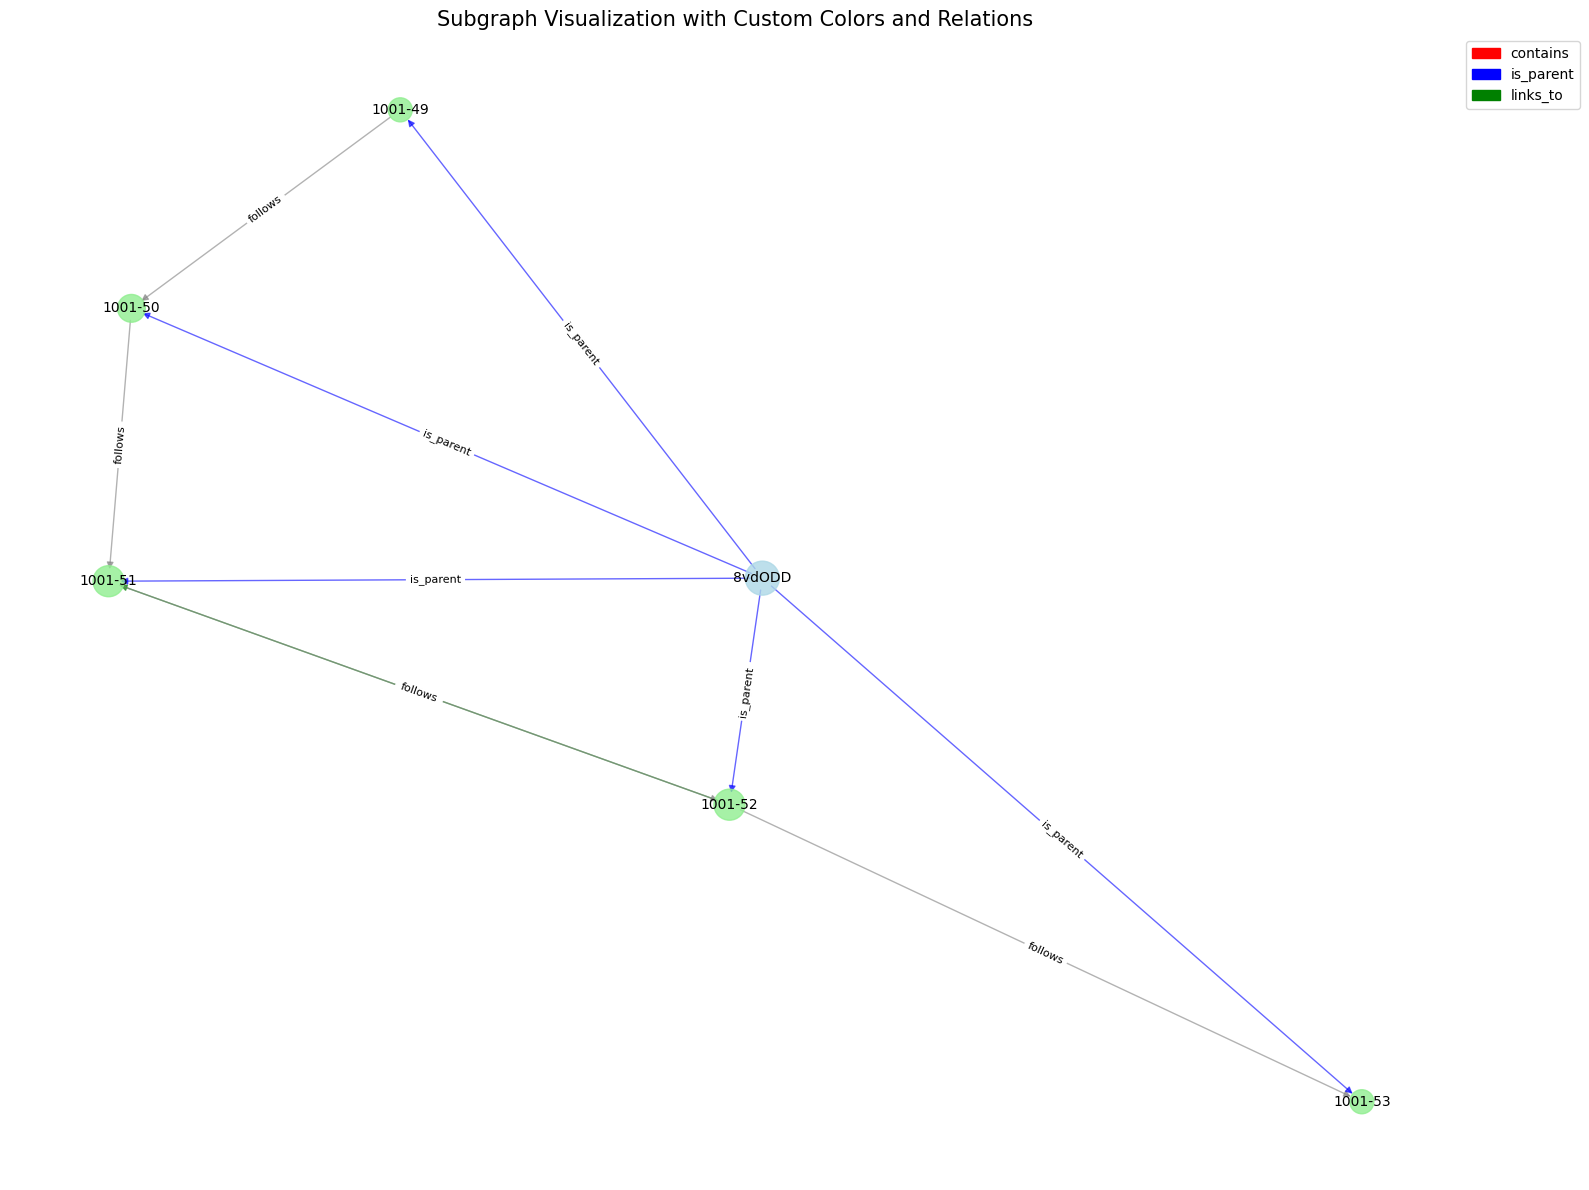

In [74]:
import json
import os
import csv
import networkx as nx
from collections import defaultdict
from typing import List, Dict, Any, Tuple, Optional
import math
import requests
import re
import matplotlib.pyplot as plt
import random 
import matplotlib.font_manager as fm
from bs4 import BeautifulSoup
import matplotlib.patches as mpatches
# 나눔글꼴 경로 설정
fe = fm.FontEntry(fname='./NanumGothic.ttf', name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})
plt.rcParams['axes.unicode_minus'] = False
available_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')
print(available_fonts)
class ElementType(str):
    # PAGE = "Page"
    TITLE = "Title"
    # FIGURE = "Figure"
    # FOOTER = "Footer"
    CLAUSE_HEADER = "Clause Header"
    LIST_ITEM = "List Item"
    HEADER = "Header"
    DOCUMENT = "Document"
    SECTION_HEADER = "Section Header"
    TEXT = "Text"
    TABLE = "Table"


ELEMENTS = [ElementType.TITLE,
            ElementType.LIST_ITEM, ElementType.HEADER, ElementType.DOCUMENT, 
            ElementType.SECTION_HEADER, ElementType.TEXT, ElementType.TABLE]

# 감사기준서 https://db.kasb.or.kr/api/standard-indexes/530
# https://db.kasb.or.kr/api/paragraphs/1001/mA9o3F?searchWord=
# 한국채택국제회계기준 (K-IFRS)

graph = nx.DiGraph()



class LexicalGraphBuilder:
    def __init__(self, file_name: str):
        self.file_name = file_name
        self.graph = graph  # Using networkx directed graph
        self.triples = []  # Store relations
        self.json_data = None
        self.elements_by_page_number = None
        self.elements = None
        self.explicit_links = None
        self.footers_by_page_number = defaultdict(list)
        self.hash_lookup_node = {}

        # # Load JSON data for elements
        # print("Loading JSON data...")
        # try:
        #     with open(os.path.join("./docs_structure", "reducto", f"{self.file_name}.json"), "r") as f:
        #         self.json_data = json.load(f)
        #     print("JSON data loaded.")
        # except FileNotFoundError:
        #     raise FileNotFoundError("JSON file not found.")

        self.elements_by_page_number = self.get_elements_sort_by_pages(self.file_name)
        self.elements = self.get_elements(self.file_name)

        self.url = "https://db.kasb.or.kr/api"
        self.index_dict = {
            1001: "재무제표 표시",
            1002: "재고자산",
            1007: "현금흐름표",
            1008: "회계정책, 회계추정치 변경과 오류",
            1010: "보고기간후사건",
            1012: "법인세",
            1016: "유형자산",
            1019: "종업원급여",
            1020: "정부보조금의 회계처리와 정부지원의 공시",
            1021: "환율변동효과",
            1023: "차입원가",
            1024: "특수관계자 공시",
            1026: "퇴직급여제도에 의한 회계처리와 보고",
            1027: "별도재무제표",
            1028: "관계기업과 공동기업에 대한 투자",
            1029: "초인플레이션 경제에서의 재무보고",
            1032: "금융상품: 표시",
            1033: "주당이익",
            1034: "중간재무보고",
            1036: "자산손상",
            1037: "충당부채, 우발부채, 우발자산",
            1038: "무형자산",
            1039: "금융상품: 인식과 측정",
            1040: "투자부동산",
            1041: "농림어업",
            1101: "한국채택국제회계기준의 최초채택",
            1102: "주식기준보상",
            1103: "사업결합",
            1105: "매각예정비유동자산과 중단영업",
            1106: "광물자원의 탐사와 평가",
            1107: "금융상품: 공시",
            1108: "영업부문",
            1109: "금융상품",
            1110: "연결재무제표",
            1111: "공동약정",
            1112: "타 기업에 대한 지분의 공시",
            1113: "공정가치 측정",
            1114: "규제연계정",
            1115: "고객과의 계약에서 생기는 수익",
            1116: "리스",
            1117: "보험계약",
            200: "독립된 감사인의 전반적인 목적 및 감사기준에 따른 감사의 수행",
            210: "감사업무 조건의 합의",
            220: "재무제표감사의 품질관리",
            230: "감사문서",
            240: "재무제표감사에서의 부정에 관한 감사인의 책임",
            250: "재무제표감사에서의 법률과 규정의 고려",
            265: "지배기구와의 커뮤니케이션",
            260: "내부통제 미비점에 대한 지배기구와 경영진과의 커뮤니케이션",
            300: "재무제표감사의 계획수립",
            315: "기업과 기업환경 이해를 통한 중요왜곡표시위험의 식별과 평가",
            320: "감사의 계획수립과 수행에 있어서의 중요성",
            330: "평가된 위험에 대한 감사인의 대응",
            402: "서비스조직을 이용하는 기업에 관한 감사 고려사항",
            450: "감사 중 식별된 왜곡표시의 평가",
            500: "감사증거",
            501: "감사증거-특정항목에 대한 구체적인 고려사항",
            505: "외부조회",
            510: "초도감사-기초잔액",
            520: "분석적절차",
            530: "표본감사",
            540: "공정가치 등 회계추정치와 관련 공시에 대한 감사",
            550: "특수관계자",
            560: "후속사건",
            570: "계속기업",
            580: "서면진술",
            600: "그룹재무제표 감사 - 부문감사인이 수행한 업무 등 특별 고려사항",
            610: "내부감사인이 수행한 업무의 활용",
            620: "감사인측 전문가가 수행한 업무의 활용",
            700: "재무제표에 대한 의견형성과 보고",
            701: "감사보고서 핵심감사사항 커뮤니케이션",
            705: "감사견해 변형",
            706: "감사보고서의 강조사항문단과 기타사항문단",
            710: "비교정보 - 대응수치 및 비교재무제표",
            720: "감사받은 재무제표를 포함하고 있는 문서 내의 기타정보와 관련된 감사인의 책임",
            800: "특정목적 재무보고체계에 따라 작성된 재무제표의 감사 - 특별 고려사항",
            805: "단위재무제표와 재무제표 특정 요소, 계정 또는 항목에 대한 감사 - 특별 고려사항",
            810: "요약재무제표에 대한 보고업무",
            1100: "내부회계관리제도의 감사",
            1200: "소규모기업 재무제표에 대한 감사",
            3002: "내부회계관리제도 설계 및 운영 개념체계",
            3003: "내부회계관리제도 평가 및 보고 모범규준",
            99: "재무회계개념체계",
            1: "목적, 구성 및 적용",
            2: "재무제표의 작성과 표시 I",
            3: "재무제표의 작성과 표시 II",
            4: "연결재무제표",
            5: "회계정책, 회계추정의 변경 및 오류",
            6: "금융자산·금융부채",
            7: "재고자산",
            8: "지분법",
            9: "조인트벤처 투자",
            10: "유형자산",
            11: "무형자산",
            12: "사업결합",
            13: "리스",
            14: "충당부채, 우발부채 및 우발자산",
            15: "자본",
            16: "수익",
            17: "정부보조금의 회계처리",
            18: "차입원가자본화",
            19: "주식기준보상",
            20: "자산손상",
            21: "종업원급여",
            22: "법인세회계",
            23: "환율변동효과",
            24: "보고기간후사건",
            25: "특수관계자 공시",
            26: "기본주당이익",
            27: "특수활동",
            28: "중단사업",
            29: "중간재무제표",
            30: "일반기업회계기준의 최초채택",
            31: "중소기업 회계처리 특례",
            32: "동일지배거래",
            33: "온실가스 배출권과 배출부채",
            60: "시행일 및 경과규정",
            91: "보험협회계제규준",
            3004: "내부회계관리제도 설계 및 운영 적용기법",
            3005: "내부회계관리제도 평가 및 보고 적용기법",
            3006: "중소기업 내부회계관리제도 설계 및 운영 적용기법",
            3007: "중소기업 내부회계관리제도 평가 및 보고 적용기법",
            3101: "내부회계관리제도 검토기준",
            3102: "내부회계관리제도 검토기준 적용지침",
            # 회계감사실무지침
            8507: "회계감사실무지침 2018-1",
            8508: "회계감사실무지침 2018-2",
            8509: "회계감사실무지침 2018-3",
            8506: "회계감사실무지침 2017-1",
            8505: "회계감사실무지침 2016-1",
            8504: "회계감사실무지침 2015-1",
            8501: "회계감사실무지침 2014-1",
            8502: "회계감사실무지침 2014-2",
            8503: "회계감사실무지침 2014-3",
            # 기타 기준서
            5001: "결합재무제표",
            5002: "기업구조조정투자회사",
            5003: "집합투자기구",
            5004: "신탁업자의 신탁계정",
            8100: "중소기업회계기준",
            8200: "비영리조직회계기준",
            8300: "기업회계기준전문",
        }
        self.index_list = list(self.index_dict.keys())
        self.index_documents_list = list()
        self._MAX_LEVEL = 5
        self._title_lookup_table: dict[int, dict[str, str]] = {}
        self._parent_document_ids_lookup_table: dict[int, dict[str, list[str]]] = {}


        self.explicit_links = []
    def _get_index_url(self, index: int):
        return f"{self.url}/standard-indexes/{index}"

    def _get_document_url(self, index: int, document_id: str):
        return f"{self.url}/paragraphs/{index}/{document_id}?searchWord="
        # json 저장

    def get_document_response(self, index) -> Dict[str, Any]:
        response = requests.get(self._get_document_url(index, index.get("documentId")))
        return response.json()

    def convert_doc_ids_to_titles(self, index_id: int, doc_ids: list[str]) -> list[str]:
        result = []
        for doc_id in doc_ids:
            try:
                result.append(self._title_lookup_table[index_id][doc_id])
            except Exception:
                result.append("")

        return result

    
    def check_whether_to_split_file(
        self, prev_level: int, curr_level: int, root_level
    ) -> bool:
        """
        파일 분리하지 않는 경우:
        이전 level이 MAX_LEVEL에 도달하고, 현재 level이 max 이전 level보다 클 때, 또는 현재 level과 이전 level이 같을 때, 또는 현재 level과 초기 level이 같을 때

        파일 분리하는 경우:

        """
        if (
            (prev_level >= self._MAX_LEVEL and prev_level < curr_level)
            or prev_level == curr_level
            or prev_level == root_level
        ):
            return False
        else:
            return True

    def fetch_all_lv0_ids_by_index_id(self, index_id: int) -> tuple[list[str], int]:
        root_level = 0
        response = requests.get(self._get_index_url(index_id)).json()
        docs_metadata = response["standardIndexes"]

        lv0s_metadata = list(
            filter(lambda doc_metadata: doc_metadata["level"] == 0, docs_metadata)
        )

        if len(lv0s_metadata) == 0:
            lv0s_metadata = list(
                filter(lambda doc_metadata: doc_metadata["level"] == 1, docs_metadata)
            )

            root_level = 1

        self._title_lookup_table[index_id] = {}
        self._parent_document_ids_lookup_table[index_id] = {}

        for doc_metadata in docs_metadata:
            self._title_lookup_table[index_id][doc_metadata["documentId"]] = (
                doc_metadata["title"]
            )
            self._title_lookup_table[index_id]["monster-sunjung"] = ""
            doc_metadata["parentDocumentIds"].reverse()
            self._parent_document_ids_lookup_table[index_id][
                doc_metadata["documentId"]
            ] = list(
                map(
                    lambda x: x if x != None else "monster-sunjung",
                    doc_metadata["parentDocumentIds"],
                )
            )

        return (
            list(map(lambda lv0_metadata: lv0_metadata["documentId"], lv0s_metadata)),
            root_level,
        )

    def remove_html_tags(self, text: str) -> str:
        clean = re.compile("<.*?>")
        return re.sub(clean, "", text)

    def count_level(self):
        count = 0
        for index in self.index_list:
            url = self._get_index_url(index)
            response = requests.get(url).json()["standardIndexes"]

            for res in response:
                if res["level"] in [3, 3.5, 4, 4.5, 5, 5.5, 6]:
                    count += 1
            count += 2
        print(count)

    def construct_graph_from_index_id(self, index_id: int):
        class_names = set()
        (lv0_ids, root_level) = self.fetch_all_lv0_ids_by_index_id(index_id)
        for lv0_id in lv0_ids:
            parent_section_id = None
            last_section_id = None
            last_clause_item_id = None
            url = self._get_document_url(index_id, lv0_id)
            response = requests.get(url).json()
            documents = response["clauses"]

            result: dict[str, dict[str, str | list[Any]]] = (
                {}
            )  # dict[파일 이름, 실제 json 값]
            result_json_data: list[dict] = []
            prev_level: int = root_level
            parent_nodes: list[str] = [lv0_id]
            for document in documents:
                try:
                    doc_type: str = document["type"]
                except Exception:
                    continue
                
                curr_level: int | None = document.get("level", None)
                node_id = document["uniqueKey"] if "uniqueKey" in document else document["documentId"]
                
                if last_section_id is None:
                    self.link_nodes(index_id, node_id, "contains")

                if doc_type == "title":
                    assert curr_level != None
                    curr_level = math.floor(curr_level)
                    graph.add_node(node_id, label="title", content=document["title"])
                    
                    if last_section_id is not None:
                        if prev_level < curr_level:
                            self.link_nodes(last_section_id, node_id, "contains")
                            parent_nodes.append(last_section_id)
                        elif prev_level == curr_level:
                            self.link_nodes(last_section_id, node_id, "follows")
                            self.link_nodes(parent_nodes[-1], node_id, "contains")
                        else:
                            level_diff = prev_level - curr_level

                            if len(parent_nodes) <= level_diff:
                                print("Error: parent_nodes length is less than level_diff")
                                print(lv0_id, document)
                                print(parent_nodes)
                            for _ in range(level_diff):
                                sibling_node = parent_nodes.pop()
                            
                            self.link_nodes(sibling_node, node_id, "follows")
                            self.link_nodes(parent_nodes[-1], node_id, "contains")
                        
                    last_clause_item_id = None
                    last_section_id = node_id
                    prev_level = curr_level
                elif doc_type == "paragraph":
                    # TODO: Link Parsing 하는 기능도 추가
                    content = document["paraContent"]
                    
                    # Parse the HTML content
                    soup = BeautifulSoup(content, 'html.parser')
                    
                    # change the code to remove only the tag but keep the content
                    # Find all tags with class "para" or "para-inner-para"
              
                    para_tags = soup.find_all(class_=["para", "para-inner-para"])
                    for tag in para_tags:
                        tag.unwrap()
                    
                    
                    mundan_tags = soup.find_all(class_="mundan-finder")
                    for tag in mundan_tags:
                        data_id = tag.get("data-id")
                        if data_id:
                            self.explicit_links.append((node_id, f"{index_id}-{data_id}"))

                    for tag in soup.find_all(class_=True):
                        # class 속성의 값을 공백으로 분리하여 각각의 class 이름을 추출
                        classes = tag.get('class', [])
                        class_names.update(classes)
                    # Return the modified HTML as a string

                    graph.add_node(node_id, label="clause", std_num=document["stdNum"], para_num=document["paraNum"], content=document["paraContent"])
                    self.link_nodes(last_section_id, node_id, "is_parent")
                    if last_clause_item_id:
                        self.link_nodes(last_clause_item_id, node_id, "follows")
                    last_clause_item_id = node_id
                else:
                    print("Invalid document type")
                    # result_json_data.append(document)
            # print or visualize graph
            # return result
        print(class_names)
        return self.graph

    def build_graph(self):
        print("Building graph with nodes and edges...")
        index_id = 1001

        self.construct_graph_from_index_id(index_id)
        self.analyse_links()
        # for reducto_chunk in self.json_data["result"]["chunks"]:
        #     for element in reducto_chunk["blocks"]:
        #         # page_number = int(element["bbox"]["page"])
        #         element_type = element["type"]
        #         content = element["content"]

        #         current_element_hash_id = self.hash_element(element)

        #         # Assign footers
        #         # if element_type == "Footer":
        #         #     self.footers_by_page_number[page_number].append(element)

        #         if element_type == "Page Number":
        #             continue

        #         node_name_content_preview = self.whyhow_unique_node_name(content, current_element_hash_id)
        #         self.graph.add_node(current_element_hash_id, label=element_type, content=content)

        #         # if page_number == 1:
        #         #     self.link_nodes("cover_page", current_element_hash_id, "contains")
        #         # else:
        #         if last_section_id is None:
        #             self.link_nodes(self.file_name, current_element_hash_id, "contains")

        #         if element_type == "Section Header":
        #             if last_section_id:
        #                 self.link_nodes(last_section_id, current_element_hash_id, "follows")
        #             last_section_id = current_element_hash_id
        #             last_clause_item_id = None
        #             self.link_nodes(self.file_name, current_element_hash_id, "contains")

        #         elif element_type == "List Item":
        #             if last_clause_item_id:
        #                 parent_id = last_clause_item_id
        #                 self.link_nodes(parent_id, current_element_hash_id, "contains")
        #             else:
        #                 self.link_nodes(last_section_id, current_element_hash_id, "is_parent")
        #             last_clause_item_id = current_element_hash_id
        #         else:
        #             self.link_nodes(last_section_id, current_element_hash_id, "is_parent")

        # for tuple_ in self.links_tuples:
        #     if tuple_[0] is not None and tuple_[1] is not None:
        #         self.link_nodes(tuple_[0], tuple_[1], "links_to")

        # print(f"Graph has been built with {self.graph.number_of_nodes()} nodes and {self.graph.number_of_edges()} edges.")

    def hash_element(self, element):
        # Create a unique hash ID for an element (simplified for example)
        return hash(json.dumps(element))

    def whyhow_unique_node_name(self, content, element_hash_id):
        # Create a unique name for a node (simplified for example)
        return f"{content[:30]}_{element_hash_id}"

    def link_nodes(self, head_hash, tail_hash, relation):
        self.graph.add_edge(head_hash, tail_hash, relation=relation)

    def get_elements_sort_by_pages(self, file_name):
        # Placeholder for actual function logic
        return {}

    def get_elements(self, file_name):
        # Placeholder for actual function logic
        return {}

    def analyse_links(self):
        for (head_node_id, tail_node_id) in self.explicit_links:
            self.link_nodes(head_node_id, tail_node_id, "links_to")


# Change the code to find title node and retrieve all of its related nodes
# Just find select one title and retrieve all of its related nodes
def get_related_nodes(graph, relation_types):
    related_nodes = set()
    document_id = "8vdODD"
    
    def dfs(node):
        if node not in related_nodes:
            related_nodes.add(node)
            for neighbor in graph.neighbors(node):
                edge_data = graph.get_edge_data(node, neighbor)
                if edge_data and 'relation' in edge_data:
                    if edge_data['relation'] in relation_types:
                        dfs(neighbor)
    
    dfs(document_id)
    return related_nodes

def visualize_graph():
    relation_types = ["contains", "is_parent", "links_to"]
    
    # Get related nodes based on specified relationships
    selected_nodes = get_related_nodes(graph, relation_types)
    selected_nodes_with_data = filter(lambda node: node[0] in selected_nodes, graph.nodes(data=True))
    

    for node in filter(lambda node: node[1].get("label") == 'title', selected_nodes_with_data):
        print(node)
    # Create a subgraph containing only the selected nodes
    subgraph = graph.subgraph(selected_nodes)

    pos = nx.spring_layout(subgraph, seed=42)
    plt.figure(figsize=(16, 12))  # Increase the size of the plot for better visibility
    
    # Define colors based on node label
    node_colors = []
    for _, data in subgraph.nodes(data=True):
        if data.get('label') == 'title':
            node_colors.append('lightblue')
        elif data.get('label') == 'clause':
            node_colors.append('lightgreen')
        else:
            node_colors.append('lightgray')
    
    # Draw nodes
    node_sizes = [100 * (subgraph.degree(n) + 1) for n in subgraph.nodes()]
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    
    # Define colors for each relation type
    relation_colors = {
        'contains': 'red',
        'is_parent': 'blue',
        'links_to': 'green'
    }
    
    # Draw edges with different colors based on relation
    for (u, v, data) in subgraph.edges(data=True):
        edge_color = relation_colors.get(data.get('relation'), 'gray')
        nx.draw_networkx_edges(subgraph, pos, edgelist=[(u, v)], edge_color=edge_color, width=1.0, alpha=0.6)
    
    # Create edge labels
    edge_labels = {}
    for (u, v, data) in subgraph.edges(data=True):
        relation = data.get('relation', '')
        if (u, v) in edge_labels:
            edge_labels[(u, v)] += f"\n{relation}"
        else:
            edge_labels[(u, v)] = relation
    
    # Draw edge labels
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)
    
    # Draw node labels
    custom_labels = {n: n for n in subgraph.nodes()}
    nx.draw_networkx_labels(subgraph, pos, labels=custom_labels, font_size=10)
    
    # Create legend
    legend_elements = [mpatches.Patch(color=color, label=relation)
                       for relation, color in relation_colors.items()]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.title("Subgraph Visualization with Custom Colors and Relations", size=15)
    plt.axis('off')  # Turn off the axis for better appearance
    plt.tight_layout()
    plt.show()
# Example usage
central_bank_doc = LexicalGraphBuilder(file_name="Central_Bank_Document")
lexical_graph = central_bank_doc.build_graph()
visualize_graph()


# Download Data to Notebook


### Grab all chunks


In [72]:
from whyhow.schemas import Chunk, Node

# Grab all chunks
docs = central_bank_doc.client.documents.get_all(
    workspace_id=WORKSPACE_ID
)
client = WhyHow(api_key=WHYHOW_API_KEY, base_url=WHYHOW_API_URL)
chunks_dict: Dict[str, Chunk] = {}


for doc in docs:
    print(f"Processing document {doc.metadata.filename}")
    current_doc_chunks = list(
        client.chunks.get_all(
            document_filename=doc.metadata.filename, include_embeddings=True
        )
    )

    skip_doc = False  # Flag to determine if the document should be skipped

    for chunk in current_doc_chunks:
        if "Type" not in chunk.content:
            skip_doc = True  # Set the flag to skip the document
            print(
                f"Skipping document {doc.metadata.filename}, it is not an elements csv file. Probably a definitions csv file."
            )
            break  # Exit the chunk loop and skip the document

    if skip_doc:
        continue  # Skip processing the rest of this document
    else:
        for chunk in current_doc_chunks:
            chunks_dict[chunk.chunk_id] = (
                chunk  # Add chunk to the dictionary with chunk ID as the key
            )

AttributeError: 'LexicalGraphBuilder' object has no attribute 'client'

In [7]:
print(f"number of chunks: {len(chunks_dict)}")


number of chunks: 195


### Get all WhyHow Nodes 
(Use Backend without SDK since not supported yet)


In [8]:
import requests
from typing import List, Dict, Any
from datetime import datetime
from whyhow.schemas import Node
import time

# wait 10 seconds for the graph to be processed
time.sleep(10)

print(f"Lexical Graph ID: {LEXICAL_GRAPH_ID.graph_id}")
def fetch_and_convert_nodes() -> Dict[str, Node]:
    """
    Fetch nodes from API and convert to Node objects.
    """
    api_url = (
        f"{WHYHOW_API_URL}/graphs/{LEXICAL_GRAPH_ID.graph_id}/nodes?limit=-1"
    )

    headers = {"x-api-key": WHYHOW_API_KEY}
    response = requests.get(api_url, headers=headers)
    response.raise_for_status()

    node_dict = {}
    response_json = response.json()

    # Access the 'nodes' key within the response
    nodes_list = response_json.get("nodes", [])

    for item in nodes_list:
        node_id = str(item["_id"])
        node = Node(
            node_id=node_id,
            label=item["label"],
            name=item["name"],
            chunk_ids=item.get("chunks", []),
            properties=item.get("properties", {}),
            created_at=(
                datetime.fromisoformat(
                    item["created_at"]["$date"].replace("Z", "+00:00")
                )
                if "created_at" in item
                else None
            ),
            updated_at=(
                datetime.fromisoformat(
                    item["updated_at"]["$date"].replace("Z", "+00:00")
                )
                if "updated_at" in item
                else None
            ),
        )
        node_dict[node_id] = node

    return node_dict


whyhow_nodes_dict = fetch_and_convert_nodes()
print(f"Number of nodes fetched: {len(whyhow_nodes_dict)}")

Lexical Graph ID: 66d82333eda622fc957cc89e
Number of nodes fetched: 195


# Index with LlamaIndex
### Convert WhyHow Nodes to Local Nodes, indexable with LlamaIndex


In [9]:
from pydantic import BaseModel, ConfigDict
from typing import List, Dict, Any, Optional, Literal
from whyhow.schemas import Triple, Node

from llama_index.core import SimpleDirectoryReader
from llama_index.core import StorageContext
from llama_index.core import Settings
from llama_index.core.schema import TextNode
from llama_index.llms.openai import OpenAI as LLamaOpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

from llama_index.core import VectorStoreIndex


Settings.llm = LLamaOpenAI(model="gpt-4o")
Settings.embed_model = OpenAIEmbedding(model_name="text-embedding-3-small")
storage_context = StorageContext.from_defaults()

client = WhyHow(api_key=WHYHOW_API_KEY, base_url=WHYHOW_API_URL)


class MultiAgentSearchLocalNode(TextNode):
    """
    An extended version of LlamaIndex's TextNode, with support for Element Types from Reducto
    Also support for chunk IDs from WhyHow
    Supports a tree-recursive print function for outputting structure as YAML for LLM calss
    """

    # A TextNode class was used because it supports indexing with LlamaIndex.
    class Config:
        arbitrary_types_allowed = True
        json_encoders = {
            ElementType: lambda v: str(
                v
            )  # Ensure ElementType is serialized as a string
        }

    type: ElementType
    chunk_id: Optional[str] = None
    embedding: Optional[List[float]] = None
    metadata: Optional[Dict[str, Any]] = None
    children: Dict[str, "MultiAgentSearchLocalNode"] = {}
    context: Optional[Dict[str, Any]] = {}

    def __init__(self, *, whyhow_node: Node, **data: Any):
        super().__init__(**data)
        try:
            chunk = chunks_dict[whyhow_node.chunk_ids[0]]
        except:
            print(
                f"Error getting chunk with chunk_id: {whyhow_node.chunk_ids[0]} for node {whyhow_node.name}"
            )
            raise ValueError("Error getting chunk with chunk_id")

        self.id_ = whyhow_node.name
        self.chunk_id = chunk.chunk_id
        self.embedding = chunk.embedding
        self.metadata = whyhow_node.properties
        self.text = chunk.content.get(
            "Content", chunk.content.get("Type", "(empty content)")
        )

    # Implement hash and eq for use in dictionaries and sets
    def __hash__(self) -> int:
        return hash(
            (
                self.node_id,
                self.chunk_id,
                tuple(self.embedding) if self.embedding else None,
            )
        )

    # Implement hash and eq for use in dictionaries and sets
    def __eq__(self, other: object) -> bool:
        if isinstance(other, MultiAgentSearchLocalNode):
            return self.node_id == other.node_id
        return False

    # print node for prompt. use yaml to save tokens + better performance than json
    # recursive tree printing function
    # GPT will return with JSON
    def print_node_prompt(self, indent_level: int = 0, show_type=False) -> str:
        cleaned_text = " ".join(self.text.split())
        indent_unit = "  "
        indent = indent_unit * indent_level

        prompt = f"""{indent}- node_id: `{self.node_id}`"""
        
        if show_type:
            prompt += f"{indent}{indent_unit*2}type: {self.type}\n"

        prompt += f"{indent}{indent_unit*2}content: {cleaned_text}"
        
        if self.context.items():
            context = ""
            for key, value in self.context.items():
                if value not in [None, "", " "]:
                    context += f"{indent}{indent_unit*3}- {key}: {value}\n"
            prompt += f"{indent}{indent_unit*2}context:\n"
            prompt += f"{context}\n"
        children = list(self.children.values())
        if len(children) > 0:
            prompt += f"{indent}{indent_unit*2}children: \n"
            for child in children:
                prompt += f"{child.print_node_prompt(indent_level = indent_level + 5)}"
        return prompt


def whyhow_node_to_local_node(whyhow_node: Node) -> MultiAgentSearchLocalNode:
    return MultiAgentSearchLocalNode(
        whyhow_node=whyhow_node, type=ElementType(whyhow_node.properties["Type"])
    )


def unique_whyhow_nodes_from_triples(
    triples: List[Triple], part_to_return: Literal["Heads", "Tails", "Both"] = "Both"
) -> List[Node]:
    unique_nodes = {}
    for triple in triples:
        if part_to_return == "Heads":
            unique_nodes[triple.head.name] = triple.head
        elif part_to_return == "Tails":
            unique_nodes[triple.tail.name] = triple.tail
        else:
            unique_nodes[triple.head.name] = triple.head
            unique_nodes[triple.tail.name] = triple.tail

    return list(unique_nodes.values())




## Creating Nodes for multi-agent search

In [ ]:
local_nodes_map: Dict[str, MultiAgentSearchLocalNode] = {}
for whyhow_node in whyhow_nodes_dict.values():
    # print(f"Processing node: {whyhow_node}")
    local_nodes_map[whyhow_node.name] = MultiAgentSearchLocalNode(
        whyhow_node=whyhow_node, type=ElementType(whyhow_node.properties["Type"])
    )

#### Making sure all nodes have the same embedding

In [11]:
min_node_embedding_length = min(
    len(node.embedding) for node in local_nodes_map.values()
)
min_chunk_embedding_length = min(len(chunk.embedding) for chunk in chunks_dict.values())

print("Minimum embedding length for nodes:", min_node_embedding_length)
print("Minimum embedding length for chunks:", min_chunk_embedding_length)

max_node_embedding_length = max(
    len(node.embedding) for node in local_nodes_map.values()
)
max_chunk_embedding_length = max(len(chunk.embedding) for chunk in chunks_dict.values())

print("Maximum embedding length for nodes:", max_node_embedding_length)
print("Maximum embedding length for chunks:", max_chunk_embedding_length)

Minimum embedding length for nodes: 1536
Minimum embedding length for chunks: 1536
Maximum embedding length for nodes: 1536
Maximum embedding length for chunks: 1536


## Hybrid Retriever (BM25 + Vector Search) with LlamaIndex
- A combination of BM25 and Vector Search

In [ ]:
from llama_index.core import QueryBundle

# import NodeWithScore
from llama_index.core.schema import NodeWithScore

from llama_index.core import SimpleKeywordTableIndex

# Retrievers
from llama_index.core.retrievers import (
    BaseRetriever,
    VectorIndexRetriever,
    KeywordTableSimpleRetriever,
)
from llama_index.retrievers.bm25 import BM25Retriever
from typing import List
import Stemmer

# Create a vector store using local nodes
vector_index = VectorStoreIndex(
    nodes=list(local_nodes_map.values()), storage_context=storage_context
)

keyword_index = SimpleKeywordTableIndex(
    nodes=list(local_nodes_map.values()), storage_context=storage_context
)


class BM25Keyword(BaseRetriever):
    """Custom retriever that performs both keyword search and BM25 search."""

    def __init__(
        self,
        mode: str = "OR",
        keyword_top_k=5,
        bm25_top_k=3,
    ) -> None:
        """Init params."""

        self._keyword_retriever = KeywordTableSimpleRetriever(
            index=keyword_index,
            max_keywords_per_query=keyword_top_k,
        )
        self._bm25_retriever = BM25Retriever.from_defaults(
            nodes=list(local_nodes_map.values()),
            similarity_top_k=bm25_top_k,
            # Optional: We can pass in the stemmer and set the language for stopwords
            # This is important for removing stopwords and stemming the query + text
            # The default is english for both
            stemmer=Stemmer.Stemmer("english"),
            language="english",
        )

        if mode not in ("AND", "OR"):
            raise ValueError("Invalid mode.")
        self._mode = mode
        super().__init__()

    def _retrieve(self, query_bundle: QueryBundle) -> List[MultiAgentSearchLocalNode]:
        """Retrieve nodes given query."""

        keyword_nodes = self._keyword_retriever.retrieve(query_bundle)
        bm25_nodes = self._bm25_retriever.retrieve(query_bundle)

        keyword_nodes_ids = {n.node.node_id for n in keyword_nodes}
        bm25_nodes_ids = {n.node.node_id for n in bm25_nodes}

        combined_dict = {n.node.node_id: n for n in keyword_nodes}
        combined_dict.update({n.node.node_id: n for n in bm25_nodes})

        if self._mode == "AND":
            retrieve_ids = keyword_nodes_ids.intersection(bm25_nodes_ids)
        else:
            retrieve_ids = keyword_nodes_ids.union(bm25_nodes_ids)

        retrieve_nodes = [combined_dict[rid] for rid in retrieve_ids]

        # print(f"Retrieved {len(retrieve_nodes)} nodes.")

        return retrieve_nodes


class VectorBM25(BaseRetriever):
    """Custom retriever that performs both semantic search and BM25 search."""

    def __init__(
        self,
        mode: str = "OR",
        vector_top_k=2,
        bm25_top_k=6,
    ) -> None:
        """Init params."""

        self._vector_retriever = VectorIndexRetriever(
            index=vector_index, similarity_top_k=vector_top_k, verbose=True
        )
        self._bm25_retriever = BM25Retriever.from_defaults(
            nodes=list(local_nodes_map.values()),
            similarity_top_k=bm25_top_k,
            # Optional: We can pass in the stemmer and set the language for stopwords
            # This is important for removing stopwords and stemming the query + text
            # The default is english for both
            stemmer=Stemmer.Stemmer("english"),
            language="english",
        )
        self._vector_top_k = vector_top_k
        self._bm25_top_k = bm25_top_k
        if mode not in ("AND", "OR"):
            raise ValueError("Invalid mode.")
        self._mode = mode
        super().__init__()

    def _retrieve(self, query_bundle: QueryBundle) -> List[MultiAgentSearchLocalNode]:
        """Retrieve nodes given query."""

        vector_nodes = self._vector_retriever.retrieve(query_bundle)
        bm25_nodes = self._bm25_retriever.retrieve(query_bundle)

        vector_ids = {n.node.node_id for n in vector_nodes}
        keyword_ids = {n.node.node_id for n in bm25_nodes}

        combined_dict = {n.node.node_id: n for n in vector_nodes}
        combined_dict.update({n.node.node_id: n for n in bm25_nodes})

        if self._mode == "AND":
            retrieve_ids = vector_ids.intersection(keyword_ids)
        else:
            retrieve_ids = vector_ids.union(keyword_ids)

        retrieve_nodes = [combined_dict[rid] for rid in retrieve_ids]

        # print(f"Retrieved {len(retrieve_nodes)} nodes.")

        return retrieve_nodes


from llama_index.core import get_response_synthesizer
from llama_index.core.query_engine import RetrieverQueryEngine

# Note: "AND" mode has qualitatively much better retriever performance,
# However, it only works best with embeddings of dim 3072. If you use "AND" mode on dim=1536, you retrieve zero nodes.
# If you want to use dim=3072, you cannot use the embeddings obtained from whyhow Nodes
# Use text-embedding-3-large. In init function of MultiAgentSearchLocalNode,
# Change this line:
# self.embedding = chunk.embedding
# To:
# self.embedding = get_text_embedding(chunk.content.get("Content", "")


# def get_text_embedding(text: str) -> List[float]:
#     response = openai_client.embeddings.create(
#         input=text,
#         model="text-embedding-3-large",
#     )
#     return response.data[0].embedding

# define custom retriever
vector_bm25_retriever = VectorBM25(vector_top_k=2, bm25_top_k=6, mode="OR")
# bm25_retriever = BM25Keyword(keyword_top_k=5, bm25_top_k=3, mode="OR")
# keyword_retriever = BM25Keyword(keyword_top_k=5, bm25_top_k=3, mode="OR")

keyword_retriever = KeywordTableSimpleRetriever(
    index=keyword_index,
    max_keywords_per_query=6,
)
bm25_retriever = BM25Retriever.from_defaults(
    nodes=list(local_nodes_map.values()),
    similarity_top_k=6,
    # Optional: We can pass in the stemmer and set the language for stopwords
    # This is important for removing stopwords and stemming the query + text
    # The default is english for both
    stemmer=Stemmer.Stemmer("english"),
    language="english",
)

keywords_bm25_retriever = BM25Keyword(keyword_top_k=5, bm25_top_k=3, mode="OR")


response_synthesizer = get_response_synthesizer()


def retrieve_with_vector_bm25(query, verbose = False):
    retrieved_nodes: NodeWithScore = vector_bm25_retriever.retrieve(
        QueryBundle(query_str=query)
    )
    retrieved_nodes_local_form: MultiAgentSearchLocalNode = [
        local_nodes_map[node.node.node_id] for node in retrieved_nodes
    ]
    if verbose:
        for node in retrieved_nodes:
            print(node)
    return retrieved_nodes_local_form


def retrieve_with_bm25(query, verbose = False):
    retrieved_nodes: NodeWithScore = bm25_retriever.retrieve(
        QueryBundle(query_str=query)
    )
    retrieved_nodes_local_form: MultiAgentSearchLocalNode = [
        local_nodes_map[node.node.node_id] for node in retrieved_nodes
    ]
    if verbose:
        for node in retrieved_nodes:
            print(node)
    return retrieved_nodes_local_form


def retrieve_with_keywords(query, verbose = False):
    retrieved_nodes: NodeWithScore = keyword_retriever.retrieve(
        QueryBundle(query_str=query)
    )
    retrieved_nodes_local_form: MultiAgentSearchLocalNode = [
        local_nodes_map[node.node.node_id] for node in retrieved_nodes
    ]
    if verbose:
        for node in retrieved_nodes:
            print(node)
    return retrieved_nodes_local_form


def retrieve_with_keywords_bm25(query, verbose = False):
    retrieved_nodes: NodeWithScore = keywords_bm25_retriever.retrieve(
        QueryBundle(query_str=query)
    )
    retrieved_nodes_local_form: MultiAgentSearchLocalNode = [
        local_nodes_map[node.node.node_id] for node in retrieved_nodes
    ]
    if verbose:
        for node in retrieved_nodes:
            print(node)
    return retrieved_nodes_local_form


# Run this code to test the retrieval of documents
# vector_bm25_retriever("Return paragraph 7.3")
retrieve_with_keywords(
    "Return paragraph 7.3 and 7.4 to answer the query: How can the Board and the CCO manage control functions?", verbose=True
)

#### Hybrid Retriever (BM25 + Vector Search) test with LLM

In [14]:
# Run this code to test the retriever + LLM answering
# print(response)
# retrieved_nodes = custom_retriever.retrieve(
#     QueryBundle(query_str="How can the Board and the CCO manage control functions?")
# )



# Recursive tree functions on subgraphs


In [15]:

from typing import Dict
from whyhow.schemas import Node
from typing import List, Any, Optional, Dict


def prune_node_from_nodes(
    nodes: List[MultiAgentSearchLocalNode],
    node_id: str,
) -> None:
    """Prune a node tree by node_id."""
    
    def prune(node: MultiAgentSearchLocalNode) -> bool:
        if node.node_id == node_id:
            return True
        to_delete = []
        for child_id, child_node in node.children.items():
            if prune(child_node):
                to_delete.append(child_id)
        for child_id in to_delete:
            del node.children[child_id]
        return False

    nodes[:] = [root_node for root_node in nodes if not prune(root_node)]


def recursive_update(
    nodes: List[MultiAgentSearchLocalNode],
    node_id: str,
    property: str,
    property_value: Any,
) -> None:
    """Recursively search a node tree by node_id and update the specified property with the given value."""

    def update_node(node: MultiAgentSearchLocalNode) -> bool:
        if node.node_id == node_id:
            setattr(node, property, property_value)
            return True
        for child in node.children.values():
            if update_node(child):
                return True
        return False

    for root_node in nodes:
        if update_node(root_node):
            break


def recursive_add_context(
    nodes: List[MultiAgentSearchLocalNode],
    node_id: str,
    context_key: str,
    context_value: str,
) -> None:
    """Recursively search a node tree by node_id and add a key-value pair to the context dictionary of the matching node."""

    def add_context_to_node(node: MultiAgentSearchLocalNode) -> bool:
        if node.node_id == node_id:
            node.context[context_key] = context_value
            return True
        for child in node.children.values():
            if add_context_to_node(child):
                return True
        return False

    for root_node in nodes:
        if add_context_to_node(root_node):
            break

    return nodes

def recursive_append_context_items(
    nodes: List[MultiAgentSearchLocalNode],
    node_id: str,
    context_key: str,
    new_items: List[str],
) -> None:
    """Recursively search a node tree by node_id and add a key-value pair to the context dictionary of the matching node."""

    def add_context_link_to_node(node: MultiAgentSearchLocalNode) -> bool:
        if node.node_id == node_id:
            node_links = node.context.get(context_key, [])
            node_links.append(new_items)
            node.context[context_key] = node_links

            return True
        for child in node.children.values():
            if add_context_link_to_node(child):
                return True
        return False

    for root_node in nodes:
        if add_context_link_to_node(root_node):
            break

    return nodes

def recursive_check_if_exists(
    nodes: List[MultiAgentSearchLocalNode],
    node_id: str,
) -> bool:
    """ Recursively search a node tree by node_id and check if the node exists."""
    
    def check_if_exists(node: MultiAgentSearchLocalNode) -> bool:
        if node.node_id == node_id:
            return True
        for child in node.children.values():
            if check_if_exists(child):
                return True
        return False

    for root_node in nodes:
        if check_if_exists(root_node):
            return True

    return False
    

# Tools for Agents

## Filtering out nodes that don't match a query

In [16]:
from typing import Dict
from whyhow.schemas import Node
from typing import List, Any, Optional, Dict

# Load environment variables
load_dotenv()

# Get OpenAI API key from environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")
if openai_api_key is None:
    raise ValueError("OPENAI_API_KEY not found in environment variables.")

# Initialize OpenAI client
openai_client = OpenAI()
openai_client.api_key = openai_api_key


class PruneNodeIdResponse(BaseModel):
    """
    Pydantic schema used to describe a node via node_id being returned by the LLM.
    """

    node_id: str
    reason: str


class PruneNodeIdsResponse(BaseModel):
    """
    Pydantic schema used to describe nodes via node_ids being returned by the LLM.
    """

    content: List[PruneNodeIdResponse]


def prune_nodes(
    query: str, current_nodes: List[MultiAgentSearchLocalNode]
) -> List[MultiAgentSearchLocalNode]:
    """
    LLM call to remove any nodes that don't contain relevant information to the query.
    """

    starter_prompt = f"""
    You are an intelligent agent responsible for post-retrieval filtration of retrieved nodes from a document. The nodes are to answer the query: 
    ```{query}```
    
    Below is a list of nodes that were automatically retrieved. Your task is to identify the nodes that do not contain relevant information to the query, and a short reason as to why they should be pruned.
    
    Be warned that deleting nodes will delete any sub-nodes listed within them.

    Nodes are identified by node_id. Return a list of (node_id, reason) where reason is a short explanation as to why the node should be pruned. node_ids must be quoted in backticks.
    
    """

    all_flattened_nodes : Dict[str, MultiAgentSearchLocalNode] = {}

    # node_id, (footer_text, further_explore_footer)

    def recurse_collect_nodes(current_nodes: List[MultiAgentSearchLocalNode]):
        """
        Recursively iterate via DFS on nodes, to index them by page number.
        """
        for node in current_nodes:
            all_flattened_nodes[node.id_] = node

            if len(node.children) > 0:
                recurse_collect_nodes(list(node.children.values()))

    recurse_collect_nodes(current_nodes)

    printout = ""
    for node in all_flattened_nodes.values():
        printout += node.print_node_prompt()

    completion = openai_client.beta.chat.completions.parse(
        model="gpt-4o-2024-08-06",
        messages=[
            {"role": "system", "content": starter_prompt},
            {"role": "user", "content": printout},
        ],
        response_format=PruneNodeIdsResponse,
    )

    node_id_response = completion.choices[0].message.parsed.content

    prune_dictionary_results: Dict[str, str] = {}

    if isinstance(node_id_response, list):
        for item in node_id_response:
            if isinstance(item, PruneNodeIdResponse):
                if item.node_id[0] == "`":
                    node_id = item.node_id[1:-1]
                else:
                    node_id = item.node_id
                # print(f"Pruning node with node_id: {node_id} due to reason: {item.reason}")
                prune_dictionary_results[node_id] = item.reason
                prune_node_from_nodes(current_nodes, node_id)



    return current_nodes, prune_dictionary_results



local_nodes = list(local_nodes_map.values())
starting_nodes = local_nodes[100:110]


print("starting:")
for node in starting_nodes:
    print(node.print_node_prompt())
    
print("="*50)
print()

nodes_test1 , _= prune_nodes("How can CCO manage control functions?", starting_nodes)


for node in nodes_test1:
    print(node.print_node_prompt())

starting:
- node_id: `(b) ensure that the CCO has sufficient stature to ..._ade5bcb25050d514e6d10e163c1581ec`    content: " (b) ensure that the CCO has sufficient stature to allow for effective engagement with the CEO and other members of senior management;"
- node_id: `(c) engage with the CCO on a regular basis2 to pro..._75d9df850bf8422349822accdcb9338e`    content: " (c) engage with the CCO on a regular basis2 to provide the opportunity for the CCO to discuss issues faced by the compliance function;"
- node_id: `(d) provide the CCO with direct and unimpeded acce..._753739a7f2c2cf4c206b6e102cf20aca`    content: " (d) provide the CCO with direct and unimpeded access to the board;"
- node_id: `(e) ensure that the CCO is supported with sufficie..._b5cb66fa679baafeacc244e3dbe13938`    content: " (e) ensure that the CCO is supported with sufficient resources, including competent officers, to perform his duties effectively; and"
- node_id: `(f) where the CCO also carries out responsibiliti

## Collecting List Item Nodes for a clause

A clause be represented by a single List Item Node, or with a combination of List Item Nodes:

```
    CLAUSE 1                   CLAUSE 2                   
    +------------------------+   +--------------------+   
    | - Clause Title 1       |   | - Clause Title 2   |   
    |    - Subclause 1.1     |   +--------------------+   
    |    - Subclause 1.2     |                            
    +------------------------+                            
```

- There is a one to many relationship between Clause Title and Subclauses
  - Clause Title 1 -> Subclause 1.1
  - Clause Title 1 -> Subclause 2.1
- Vector/keyword search might only fetch a title or the subclause.
- We would have to traverse the nodes to fetch the whole clause.
  - Example (Assume there are only two levels: clause and subclause):
  ```
    # Example
    # Input:  [Section_Heading, Text, List_Item(Subclause 1.2), Image]

    # Output: [Section_Heading, Text, List_Item(Clause 1 Title), Image]
    #                                   └── [List_Item(Subclause 1.1), List_Item(Subclause 1.2)]
  ```

  Since we have a depth of 2 max, we will have to run the query twice to guarantee we will fetch the whole clause
    - Step 1: fetch any titles of subclauses. this step will have fetched us all clause titles
      - We will get Triples of X contains List Item Y
        - If a non List Item X contains List Item Y, by deduction, we can say that List Item Y is a clause title since there is nothing above it
        - If a List Item X contains List Item Y, by deduction, we can say that List Item Y is a subclause since there is a List Item above containing it. And by definition, List Item X is a clause title
    - Step 2: based on all clause titles fetched in Step 1, we can fetch all subclauses.
      - We look for Triples of List Item X contains List Item Y
      - List Item X is clause title from Step 1, and thus List Item Y is a subclause


In [17]:
from collections import defaultdict
from typing import Set, Dict, List
from whyhow.schemas import Triple, Node, Query

def print_triple(triple: Triple):
    print("----------------------------------------------------")
    print(f"Head:{triple.head.name} of type {triple.head.label}")
    print(f"Relation: {triple.relation.name}")
    print(f"Tail: {triple.tail.name} of type {triple.tail.label}")
    
    

def fetch_whole_clause_lists(
    current_nodes: List[MultiAgentSearchLocalNode], query_client=None
) -> List[MultiAgentSearchLocalNode]:
    """
    Given a list of nodes will retrieve and replace subclauses with full clauses.
    Assumes that we have a flat sequence of nodes, not a tree of nodes.
    """
    # (Assume there are only two levels: clause and subclause)
    # Example
    # Input:  [Section_Heading, Text, List_Item(Subclause 1.2), Image]

    # Output: [Section_Heading, Text, List_Item(Clause 1 Title), Image]
    #                                   └── [List_Item(Subclause 1.1), List_Item(Subclause 1.2)]
    if query_client is None:
        query_client = WhyHow(api_key=WHYHOW_API_KEY, base_url=WHYHOW_API_URL)

    # this query is to fetch all clause titles
    first_pass_query: Query = query_client.graphs.query_structured(
        graph_id=LEXICAL_GRAPH_ID.graph_id,
        entities=[ElementType.LIST_ITEM],
        relations=["contains", "is_parent"],
        values=[
            node.id_ for node in current_nodes if node.type == ElementType.LIST_ITEM
        ],
    )
    
    # keep track of all clause title ids and subclause ids
    clause_title_ids : Set[str] = set()
    subclause_ids : Set[str] = set()
    
    # keep track of list_item to nodes
    id_to_node_dict : Dict[str, MultiAgentSearchLocalNode] = {}
    
    # keep track of which clauses map to which subclauses and vice versa
    clause_to_subclauses_map: Dict[str, List[str]] = defaultdict(list)
    subclause_to_clause_map: Dict[str, str] = {}
    

    for triple in first_pass_query.triples:
        # print_triple(triple)
        # if a list contains a list item, head is clause title, tail is subclause
        if triple.head.label == ElementType.LIST_ITEM and triple.tail.label == ElementType.LIST_ITEM:
            clause_title_ids.add(triple.head.name) 
            subclause_ids.add(triple.tail.name)
            
            clause_to_subclauses_map[triple.head.name].append(triple.tail.name)
            subclause_to_clause_map[triple.tail.name] = triple.head.name
            
            # subclause node
            tail_node = whyhow_node_to_local_node(triple.tail)
            # if clause title node exists, add subclause to its children
            if triple.head.name in id_to_node_dict:
                id_to_node_dict[triple.head.name].children[triple.tail.name]=tail_node
            else:
                # else just create a new clause title node with no children
                id_to_node_dict[triple.head.name] = whyhow_node_to_local_node(triple.head)
            # add subclause node to the map
            id_to_node_dict[triple.tail.name] = tail_node
            
        # if a list contains a non-list item, tail is clause title (we don't know if they might have subclauses below. that's for the 2nd pass)
        elif triple.head.label != ElementType.LIST_ITEM and triple.tail.label == ElementType.LIST_ITEM:
            clause_title_ids.add(triple.tail.name)
            id_to_node_dict[triple.tail.name] = whyhow_node_to_local_node(triple.tail)
        
            

    # we have determined all title clauses from the first pass.
    # second pass of query is to fetch all subclauses
    second_pass_query = query_client.graphs.query_structured(
        graph_id=LEXICAL_GRAPH_ID.graph_id,
        entities=[ElementType.LIST_ITEM],
        relations=["contains"],
        values=list(clause_title_ids)
    )

    for triple in second_pass_query.triples:
        # print_triple(triple)
        # if a list contains a list item, head is clause title, tail is subclause
        if triple.head.label == ElementType.LIST_ITEM and triple.tail.label == ElementType.LIST_ITEM:
            clause_title_ids.add(triple.head.name)
            subclause_ids.add(triple.tail.name)
            
            clause_to_subclauses_map[triple.head.name].append(triple.tail.name)
            subclause_to_clause_map[triple.tail.name] = triple.head.name

            # subclause node
            tail_node = whyhow_node_to_local_node(triple.tail)
            # if clause title node exists, add subclause to its children
            if triple.head.name in id_to_node_dict:
                id_to_node_dict[triple.head.name].children[tail_node.id_]=tail_node
            else:
                # else just create a new clause title node with no children
                id_to_node_dict[triple.head.name] = whyhow_node_to_local_node(triple.head)
            # add subclause node to the map
            id_to_node_dict[triple.tail.name] = tail_node

    # create a set of unseen clause titles
    clause_titles_ids_set: Set[str] = set(clause_title_ids)

    final_nodes = []
    for current_node in current_nodes:
        # print(f"Current node: {current_node.type} {current_node.id_}")
        # if not a list item, ignore
        if current_node.type != ElementType.LIST_ITEM:
            final_nodes.append(current_node)
            continue
        # elif we see a clause item, link any subclauses to it
        elif current_node.id_ in clause_titles_ids_set:
            # mark clause as seen by removing it from the set of unseen clauses
            clause_titles_ids_set.remove(current_node.id_)
            # replace clause node with one that contains all subclauses
            final_node_to_append = id_to_node_dict[current_node.id_]
            final_nodes.append(final_node_to_append)
        # elif we see a subclause item
        elif current_node.id_ in subclause_ids:
            # look up the subclause's parent clause id
            clause = subclause_to_clause_map[current_node.id_]
            # if its clause id is unseen, replace the subclause with the full clause that contains all subclauses
            if clause in clause_titles_ids_set:
                clause_titles_ids_set.remove(clause)
                final_node_to_append = id_to_node_dict[clause]
                final_nodes.append(final_node_to_append)
            # otherwise, if this subclause is part of a clause we have seen before, don't add it in

    return final_nodes


local_nodes = list(local_nodes_map.values())
starting_nodes = local_nodes[139:141]

nodes_test = fetch_whole_clause_lists(starting_nodes)

print("PROMPT:")
for node in nodes_test:
    print(node.print_node_prompt())

PROMPT:
- node_id: `- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd`    content: "- S 7.3 Where the CCO also assumes responsibilities for other control functions, the CCO must ensure that his independence and ability to provide sufficient time, focus and commitment to his responsibilities in respect of the compliance function is not impaired."
- node_id: `- S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3`    content: "- S 7.4 In relation to paragraphs 7.2 and 7.3-"    children: 
          - node_id: `(a) the board must approve the sharing of complian..._c98e9a54d02d6b13b61c5d1ed01ff30f`              content: " (a) the board must approve the sharing of compliance function responsibilities between a dedicated compliance unit and other control functions; and"          - node_id: `(b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c`              content: " (b) compliance function respons

## Definition Agent Search

In [18]:
from whyhow import WhyHow

def definitions_search(query: str, client: Optional[WhyHow]=None) -> Dict[str, str]:
    """
    Search for definitions of terms in a question prompt and return them as a dictionary.
    """
    if client is None:
        client = WhyHow(api_key=WHYHOW_API_KEY, base_url=WHYHOW_API_URL)
        
    query_prompt = f"""Return me definitions for the terms in this query: "{query}" Return only relevant terms that exist in the query. Ensure the term-definition pairs are separated by newlines, properly capitalised. """

    definitions_response = client.graphs.query_unstructured(
        graph_id=definitions_graph.graph_id,
        query=query_prompt,
    )
    
    response_text = definitions_response.answer
    term_def_pairs = response_text.split('\n')
    definitions_dict = {}
    
    for pair in term_def_pairs:
        if ':' in pair:
            term, definition = pair.split(':', 1)
            definitions_dict[term.strip()] = definition.strip()
    
    return definitions_dict



definitions_dict = definitions_search("How can the Board and the CCO manage control functions?")


def print_prompt_definitions_dict(definitions_dict):
    prompt = "Relevant Definitions:\n"
    for term, definition in definitions_dict.items():
        prompt += f"{term}: {definition}\n"
    return prompt

print(print_prompt_definitions_dict(definitions_dict))
print(definitions_dict)

Relevant Definitions:
Board: The board of directors of a financial institution, including a committee of the board where the responsibilities of the board set out in this policy document have been delegated to such a committee.
Control Function: A function that has a responsibility independent from business lines to provide objective assessment, reporting or assurance. This includes the risk management function, the compliance function and the internal audit function.
Chief Compliance Officer: The senior officer of a financial institution, however styled, who is the central point of authority for a financial institution's compliance matters and is responsible for providing an institution-wide view on the management of compliance risk.

{'Board': 'The board of directors of a financial institution, including a committee of the board where the responsibilities of the board set out in this policy document have been delegated to such a committee.', 'Control Function': 'A function that has a

# Updating Node Context with Footer Info

In [19]:
from typing import Dict
from whyhow.schemas import Node
from typing import List, Any, Optional, Dict

# Load environment variables
load_dotenv()

# Get OpenAI API key from environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")
if openai_api_key is None:
    raise ValueError("OPENAI_API_KEY not found in environment variables.")

# Initialize OpenAI client
openai_client = OpenAI()
openai_client.api_key = openai_api_key


footer_nodes_by_page_number: Dict[int, List[MultiAgentSearchLocalNode]] = defaultdict(
    list
)

# build a map of footer nodes by page number
for node_id, node in local_nodes_map.items():
    if node.type == ElementType.FOOTER:
        page_number = int(node.metadata["Page Number"])
        footer_nodes_by_page_number[page_number].append(node)


class NodeIdFooterResponse(BaseModel):
    """
    Pydantic schema used to describe the structured output of node-id to footer info pair
    """

    node_id: str
    footer_text: str
    further_explore_footer: bool


class NodeIdFooterResponses(BaseModel):
    """
    Pydantic schema used to describe the structured output of node-id to footer info pairs.
    """

    content: List[NodeIdFooterResponse]


def fill_nodes_with_footer_context(
    query: str, current_nodes: List[MultiAgentSearchLocalNode]
) -> Tuple[List[MultiAgentSearchLocalNode], int]:
    """
    Takes nodes and returns a list of footer contexts to fill them with.
    """

    starter_prompt = f"""
    You are an agent responsible for the structured extraction of a document page to answer the question:
    ```{query}```
    Below are two lists of OCR'd text, one for nodes and one for footers. All the text was taken from one page. Some of these nodes make references to the footers below, possibly through footnote numbers.

    Your task is, for each node_id, to identify if it contains (1) any footer information, and (2) if the footer requires further reading ON THE SAME DOCUMENT. Return only node_ids that contain footer info.
    
    For each node:
    1. deduce from the context and footnode numbering if any footer content might be relevant to the node given the query. If so, extract that footer content (it can be a partial or whole extract) and assign it to the node. If there is no footer info, SKIP the node. Only return nodes that have footer content.
    
    2. Some of the footer content may require the reader to consult other parts of the document (it must be an internal link pointing to other paragraphs/sections, not external reading). If so, set the further_explore_footer flag to true, else false.

    Then return a list of (node_id, relevant_footer_content, further_explore_footer). node_ids must be quoted in backticks.
    
    """

    nodes_by_page_number: Dict[int, List[MultiAgentSearchLocalNode]] = defaultdict(list)
    
    # collection of which nodes to mark with footer context
                            #node_id, (footer_text, further_explore_footer) 
    node_id_footer_context: Dict[str, Tuple[str, bool]] = {}
    
    
    def recurse_index_nodes(current_nodes: List[MultiAgentSearchLocalNode]):
        """
        Recursively iterate via DFS on nodes, to index them by page number.
        """
        for node in current_nodes:
            page_number = int(node.metadata["Page Number"])
            nodes_by_page_number[page_number].append(node)

            if len(node.children) > 0:
                recurse_index_nodes(list(node.children.values()))

    recurse_index_nodes(current_nodes)

    for page_number, nodes in nodes_by_page_number.items():

        printout_of_curent_nodes = f"Nodes on page {page_number}"
        for node in nodes:
            printout_of_curent_nodes += node.print_node_prompt()

        printout_of_footers = f"Footers on page {page_number}:"
        for footer in footer_nodes_by_page_number[page_number]:
            printout_of_footers += footer.print_node_prompt()

        completion = openai_client.beta.chat.completions.parse(
            model="gpt-4o-2024-08-06",
            messages=[
                {"role": "system", "content": starter_prompt},
                {"role": "user", "content": printout_of_curent_nodes},
                {"role": "user", "content": printout_of_footers},
            ],
            response_format=NodeIdFooterResponses,
        )

        node_id_footer_response = completion.choices[0].message.parsed.content

        if isinstance(node_id_footer_response, list):
            for item in node_id_footer_response:
                if isinstance(item, NodeIdFooterResponse):
                    # sometimes GPT returns node ids with or without backticks
                    if item.node_id[0] == "`":
                        node_id = item.node_id[1:-1]
                    else:
                        node_id = item.node_id
                    node_id_footer_context[node_id] = (item.footer_text, item.further_explore_footer)

    change_count = 0
    # Based on the dict of node_id - footer context
    for node_id, (footer_text, further_explore_footer) in node_id_footer_context.items():
        # some LLM calls 
        if footer_text not in ["", " ", None]:
            # print(f"node_id: {node_id}, footer_text: '{footer_text}', further_explore_footer: {further_explore_footer}")
            recursive_add_context(current_nodes, node_id, "footer info", footer_text)
            recursive_add_context(current_nodes, node_id, "further explore footer?", str(further_explore_footer))
            change_count += 1

    return current_nodes, change_count


local_nodes = list(local_nodes_map.values())
starting_nodes = local_nodes[100:110]

nodes_test1 = fetch_whole_clause_lists(starting_nodes)
nodes_test2, change_count = fill_nodes_with_footer_context("What general information is in my footer?", nodes_test1)


for node in nodes_test2:
    print(node.print_node_prompt())
    
print(f"Number of nodes changed: {change_count}")
    
    


- node_id: `- S 6.3 In relation to the position of the CCO, th..._d9432f9931c5bf206db8317a67e69052`    content: "- S 6.3 In relation to the position of the CCO, the board must-"    children: 
          - node_id: `(c) engage with the CCO on a regular basis2 to pro..._75d9df850bf8422349822accdcb9338e`              content: " (c) engage with the CCO on a regular basis2 to provide the opportunity for the CCO to discuss issues faced by the compliance function;"              context:
                - footer info: The board should also consider engaging the CCO without the presence of other members of senior management from time to time.
                - further explore footer?: False

          - node_id: `(d) provide the CCO with direct and unimpeded acce..._753739a7f2c2cf4c206b6e102cf20aca`              content: " (d) provide the CCO with direct and unimpeded access to the board;"          - node_id: `(e) ensure that the CCO is supported with sufficie..._b5cb66fa679baafeacc244e3dbe13938

# Updating Node Context with Link Info
- For a given node, add hints to the nodes that say it is linked to other nodes


- Note: WhyHow only has one identifying field for a node, called 'node_name', and it has to be unique. 
  - Due to this, Node name and id mean the same thing. On the UI, it shows node_name to the user
  - The way we structured this notebook is to use a preview (first 50 characters of element content) + a hash of the reducto element to use as node_name/node_id
- This comes with some benefits. For every node with links, we make it have a hint that says (to the LLM reading it), "hey, I have a link to these node_ids: [list of linked nodes by ID]"
- These node_ids also contain a preview (first 50 characters), so the LLM can decide if it needs to explore/follow the links or not

In [20]:
def fill_nodes_with_link_hints(
    current_nodes: List[MultiAgentSearchLocalNode], query_client=None
) -> Tuple[List[MultiAgentSearchLocalNode], int]:
    """
    Given a tree/list of nodes, update the nodes with hints to the LLM if any of the nodes contain links.
    """

    if query_client is None:
        query_client = WhyHow(api_key=WHYHOW_API_KEY, base_url=WHYHOW_API_URL)

    # some nodes are nested, so recurse to get all nodes
    flattened_nodes: Dict[str, MultiAgentSearchLocalNode] = {}

    link_dict : Dict[str, List[str]] = defaultdict(list)

    def recurse_index_nodes(current_nodes: List[MultiAgentSearchLocalNode]):
        for node in current_nodes:
            flattened_nodes[node.id_] = node


            if len(node.children) > 0:
                recurse_index_nodes(list(node.children.values()))

    recurse_index_nodes(current_nodes)

    # fetch all elements are in a link_to triple containing the current_nodes
    links_query: Query = query_client.graphs.query_structured(
        graph_id=LEXICAL_GRAPH_ID.graph_id,
        entities=ELEMENTS,
        relations=["links_to"],
        values= list(flattened_nodes.keys()),
    )

    # head links_to tail
    # if the head is in our flattened nodes, then it links to tail
    # we could repeat in reverse to get backlinks (like Obsidian), but out of scope.
    for triple in links_query.triples:
        if triple.head.name in flattened_nodes.keys():
            link_dict[triple.head.name].append(triple.tail.name)
            
    # recurse through the whole graph and add context markers inside any node with a link
    # show the llm hints that some clauses/text/etc link to external parts
    change_count = 0
    for link_node_id, destinations in link_dict.items():
        recursive_append_context_items(current_nodes, link_node_id,"link", str(destinations))
        change_count +=1
        
    return current_nodes, change_count


local_nodes = list(local_nodes_map.values())
starting_nodes = local_nodes[100:120]
nodes_test2 = fetch_whole_clause_lists(starting_nodes)
nodes_test3, change_count = fill_nodes_with_link_hints(nodes_test2)
nodes_test4, change_count = fill_nodes_with_footer_context("What general information is in my footer?",nodes_test3)


for node in nodes_test4:
    print(node.print_node_prompt())

print(change_count)    

- node_id: `- S 6.3 In relation to the position of the CCO, th..._d9432f9931c5bf206db8317a67e69052`    content: "- S 6.3 In relation to the position of the CCO, the board must-"    children: 
          - node_id: `(c) engage with the CCO on a regular basis2 to pro..._75d9df850bf8422349822accdcb9338e`              content: " (c) engage with the CCO on a regular basis2 to provide the opportunity for the CCO to discuss issues faced by the compliance function;"              context:
                - footer info: The board should also consider engaging the CCO without the presence of other members of senior management from time to time.
                - further explore footer?: False

          - node_id: `(d) provide the CCO with direct and unimpeded acce..._753739a7f2c2cf4c206b6e102cf20aca`              content: " (d) provide the CCO with direct and unimpeded access to the board;"          - node_id: `(e) ensure that the CCO is supported with sufficie..._b5cb66fa679baafeacc244e3dbe13938

# MY Central Bank Question:

- How can the Board and the CCO manage control functions?

## Ideal flow:

- Gives me a definition of CCO from definition page
- Retrieval of clauses from 6.3, 7.2.
- Detection of “Refer to Para 7.3 and 7.4”.
- Pulls in Para 7.3 and 7.4, which mentions Para 9.1


# Langgraph

![](./langgraph.png)

In [23]:
# Define the State
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph import END, StateGraph, START

import tiktoken

tokenizer = tiktoken.get_encoding("o200k_base")

TOKEN_LIMIT = 32000


def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))


def count_tokens_for_nodes(nodes: List[MultiAgentSearchLocalNode]) -> int:
    return sum(count_tokens(node.print_node_prompt()) for node in nodes)


debug_markdown = "# Multi-Agent Log\n"
debug_markdown += "## Pass 1\n"


class AgentState(TypedDict):
    # we keep track of existing messages
    query: str
    definitions: Dict[str, str]
    previous_nodes: List[MultiAgentSearchLocalNode]
    last_fetched_context_nodes: List[MultiAgentSearchLocalNode]
    node_links_to_fetch: List[str]
    node_footers_to_fetch: Dict[str, str]
    allow_continue: bool
    search_failures: List[str]
    markdown_debug: str
    pass_count: int


def inital_search_agent(state: AgentState) -> AgentState:
    state["markdown_debug"] += f"### Initial Search Agent\n"
    
    vector_bm25_retriever = VectorBM25(vector_top_k=1, bm25_top_k=7, mode="OR")
    def retrieve_with_vector_bm25(query, verbose = False):
        retrieved_nodes: NodeWithScore = vector_bm25_retriever.retrieve(
            QueryBundle(query_str=query)
        )
        retrieved_nodes_local_form: MultiAgentSearchLocalNode = [
            local_nodes_map[node.node.node_id] for node in retrieved_nodes
        ]
        if verbose:
            for node in retrieved_nodes:
                print(node)
        return retrieved_nodes_local_form

    # fetch nodes by vector and bm25 search
    initial_retrieved_nodes = retrieve_with_vector_bm25(state["query"])

    # LLM prunes nodes that are not relevant
    initial_pruned_nodes, _ = prune_nodes(state["query"], initial_retrieved_nodes)

    state[
        "markdown_debug"
    ] += f" - retrieved {len(initial_retrieved_nodes)} nodes, pruned to {len(initial_pruned_nodes)} nodes\n"

    state["last_fetched_context_nodes"] = initial_pruned_nodes
    return state


def definition_agent(state: AgentState) -> AgentState:
    # fetch definitions
    state["markdown_debug"] += f"### Definitions Agent\n"
    print(f"query: {state['query']}")
    definitions_dict = definitions_search(state["query"])
    print(f"dfns: {definitions_dict}")
    state["definitions"] = definitions_dict

    state["markdown_debug"] += f"Retrieved {len(definitions_dict)} definitions for: \n"
    for term, definition in definitions_dict.items():
        state["markdown_debug"] += f"  - **{term}** : {definition}\n"
    return state


def context_fetch_tool(state: AgentState) -> AgentState:
    state["markdown_debug"] += f"### Context Fetched for nodes:\n"
    current_nodes = state["last_fetched_context_nodes"]

    # expand search to get full clauses
    full_clause_nodes = fetch_whole_clause_lists(current_nodes)

    # mark links with nodes
    full_clause_nodes_with_link_hints, change_count = fill_nodes_with_link_hints(
        full_clause_nodes
    )

    state["last_fetched_context_nodes"] = full_clause_nodes_with_link_hints
    state[
        "markdown_debug"
    ] += f"- fetched full clauses, added to {len(full_clause_nodes_with_link_hints)} nodes. {change_count} new links\n"

    return state


def footer_parsing_agent(state: AgentState) -> AgentState:
    # fill nodes with footer context
    try:
        current_nodes, changes_count = fill_nodes_with_footer_context(
            state["query"], state["last_fetched_context_nodes"]
        )

        state["last_fetched_context_nodes"] = current_nodes
        state["markdown_debug"] += f"- filled nodes with footer context\n"

        state["markdown_debug"] += f"\n```\n"
        for node in current_nodes:
            state["markdown_debug"] += node.print_node_prompt()

        state["markdown_debug"] += f"\n```\n"
        
    except:
        state["search_failures"].append("footer parsing failed.")
        state["markdown_debug"] += f"- footer parsing failed\n"

    return state


def supervisor_agent(state: AgentState) -> AgentState:
    state["markdown_debug"] += f"### Supervisor Agent\n"
    # Look for search failures. This might be an instance where multiple searches were made for certain parts of the document, but no relevant information was found.
    # This means that the search has to be ended prematurely to prevent infinite loops.
    printout = ""
    for node in state["previous_nodes"]:
        printout += node.print_node_prompt()
    for node in state["last_fetched_context_nodes"]:
        printout += node.print_node_prompt()

    prompt = f"""
You are a supervisor agent overseeing the multi-agent retrieval process of graph nodes from a document. The nodes are to answer the query:
```{state['query']}```


Below is a list of nodes that were automatically retrieved, followed by a list of errors. If there are many similar, repeated errors in the retrieval process , where no further linked or relevant nodes could be retrieved, return END to end the process. Else return CONTINUE. 
Return only a single word, either END or CONTINUE.
"""

    completion = openai_client.beta.chat.completions.parse(
        model="gpt-4o-2024-08-06",
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": printout},
            {"role": "user", "content": str(state["search_failures"])},
        ],
    )

    response: str = completion.choices[0].message.content

    if "end" in response.lower():
        state["allow_continue"] = False
        return state
    state["markdown_debug"] += f"- **supervisor**: continue\n"

    # check if requests will be in token limit
    # chatgpt is 32k, use 32k as baseline
    tokens = count_tokens_for_nodes(state["previous_nodes"]) + count_tokens_for_nodes(
        state["last_fetched_context_nodes"]
    )
    if tokens > TOKEN_LIMIT:
        state["markdown_debug"] += f"- warning: tokens over recommended limit\n"
        previous_nodes, changes_1 = prune_nodes(state["query"], state["previous_nodes"])
        last_fetched_context_nodes, changes_2 = prune_nodes(
            state["query"], state["last_fetched_context_nodes"]
        )
        new_tokens = count_tokens_for_nodes(state["previous_nodes"]) + count_tokens(
            state["last_fetched_context_nodes"]
        )

        if new_tokens > TOKEN_LIMIT:
            # raise ValueError("Too many tokens")
            print("Warning: Tried pruning, but still too many tokens")
            state[
                "markdown_debug"
            ] += f"- Warning: Tried pruning, but still too many tokens\n"
        if new_tokens < tokens:
            state["previous_nodes"] = previous_nodes
            state["last_fetched_context_nodes"] = last_fetched_context_nodes

            for node_id, reason in changes_1.items():
                state["markdown_debug"] += f"- pruned node {node_id} due to {reason}\n"

            for node_id, reason in changes_2.items():
                state["markdown_debug"] += f"- pruned node {node_id} due to {reason}\n"

    return state


class FooterSearchResponse(BaseModel):
    """
    Pydantic schema used to contain the response for a node that needs a footer search, and the query involved.
    """

    node_id: str
    search_query: str


class RouterAgentFooterResponse(BaseModel):
    """
    Pydantic schema used to describe the structured output of the router agent.
    """

    node_ids_for_footer_search: List[FooterSearchResponse]
    
class RouterAgentLinkResponse(BaseModel):
    """
    Pydantic schema used to describe the structured output of the router agent.
    """

    node_ids_for_link_retrieval: List[str]


def router_agent(state: AgentState) -> AgentState:
    # decide if process should should stop or continue
    state["markdown_debug"] += f"### Router Agent\n"

    starter_prompt_footer = f"""
        You are an intelligent agent overseeing a multi-agent retrieval process of graph nodes from a document. These nodes are to answer the query: 
        ```{state['query']}```
        
        Below this request is a list of nodes that were automatically retrieved. 
        
        You must determine if the list of nodes is enough to answer the query. If there isn't enough information, you must identify any relevant footer information in the nodes.
        
        A node can footer information asking to look in another section/part of the document, which will require a separate natural language search. 
        Example: If the footer says "see paragraph x", a search query e.g. "Return paragraph x to answer the query '{state['query']}'" should be made. 
    
        If there are no further nodes worth analysing, return an empty response. ONLY RETURN QUERIES FOR FOOTERS THAT ARE RELEVANT TO ANSWERING THE QUERY
        
        Else, if any relevant nodes require a footer search, specify the node_id and the search query.
        Nodes are identified by node_id and must be quoted in backticks.

        
    """
    
    starter_prompt_link = f"""
        You are an intelligent agent overseeing a multi-agent retrieval process of graph nodes from a document. These nodes are to answer the query: 
        ```{state['query']}```
        
        Below this request is a list of nodes that were automatically retrieved. 
        
        You must determine if the list of nodes is enough to answer the query. If there isn't enough information, you must identify any linked nodes that could be worth exploring.
        
        If there are no further nodes worth analysing, return an empty response.
        
        Return a list of node_ids. ONLY RETURN NODE_IDS for NODES THAT ARE RELEVANT TO ANSWERING THE QUERY. Nodes are identified by node_id and must be quoted in backticks.
    """
    
    # collect latest nodes, and all nodes
    last_fetched_nodes_flattened: Dict[str, MultiAgentSearchLocalNode] = {}
    all_nodes_flattened: Dict[str, MultiAgentSearchLocalNode] = {}

    def recurse_collect_last_fetched_nodes(
        current_nodes: List[MultiAgentSearchLocalNode],
    ):
        """
        Recursively iterate via DFS on nodes, to index them by page number.
        """
        for node in current_nodes:
            last_fetched_nodes_flattened[node.id_] = node
            all_nodes_flattened[node.id_] = node

            if len(node.children) > 0:
                recurse_collect_last_fetched_nodes(list(node.children.values()))

    recurse_collect_last_fetched_nodes(state["last_fetched_context_nodes"])

    def recurse_collect_all_nodes(current_nodes: List[MultiAgentSearchLocalNode]):
        """
        Recursively iterate via DFS on nodes, to index them by page number.
        """
        for node in current_nodes:
            all_nodes_flattened[node.id_] = node

            if len(node.children) > 0:
                recurse_collect_all_nodes(list(node.children.values()))

    recurse_collect_all_nodes(state["last_fetched_context_nodes"])

    printout = ""
    for node in last_fetched_nodes_flattened.values():
        printout += node.print_node_prompt()

    completion = openai_client.beta.chat.completions.parse(
        model="gpt-4o-2024-08-06",
        messages=[
            {"role": "system", "content": starter_prompt_link},
            {"role": "user", "content": printout},
        ],
        response_format=RouterAgentLinkResponse,
    )

    # Parse the response content 
    explore_response = json.loads(completion.choices[0].message.content)
    print(f"explore_response: {explore_response}")

    # Extract node_ids_for_link_retrieval
    # Ensure that the node_ids are not already in the all_nodes_flattened
    node_ids_for_link_retrieval = []
    for node_id in explore_response["node_ids_for_link_retrieval"]:
        # sometimes GPT returns node ids with or without backticks
        if node_id[0] == "`":
            node_id = node_id[1:-1]
        if all_nodes_flattened.get(node_id) is None:
            node_ids_for_link_retrieval.append(node_id)

    print(f"node_ids_for_link_retrieval: {node_ids_for_link_retrieval}")


    completion = openai_client.beta.chat.completions.parse(
        model="gpt-4o-2024-08-06",
        messages=[
            {"role": "system", "content": starter_prompt_footer},
            {"role": "user", "content": printout},
        ],
        response_format=RouterAgentFooterResponse,
    )

    # Parse the response content 
    explore_response = json.loads(completion.choices[0].message.content)
    print(f"explore_response: {explore_response}")

    # Initialize the dictionary for node_ids_for_footer_search
    node_ids_for_footer_search = {}

    # Populate the dictionary with node_id and search_query pairs
    # Must be new pairs, so not existing in all_nodes_flattened
    for footer_response in explore_response["node_ids_for_footer_search"]:
        node_id = footer_response["node_id"]
        # sometimes GPT returns node ids with or without backticks
        if node_id[0] == "`":
            node_id = node_id[1:-1]

        node_ids_for_footer_search[node_id] = footer_response["search_query"]

    # Update the state with the node_ids_for_link_retrieval and node_ids_for_footer_search
    state["node_links_to_fetch"] = node_ids_for_link_retrieval
    state["node_footers_to_fetch"] = node_ids_for_footer_search

    # debug prints
    state[
        "markdown_debug"
    ] += f"- found {len(node_ids_for_link_retrieval)} nodes to fetch links for\n"
    for node_id in node_ids_for_link_retrieval:
        state["markdown_debug"] += f"    - {node_id}\n"
    state[
        "markdown_debug"
    ] += f" - found {len(node_ids_for_footer_search)} nodes to fetch footers for\n"
    for node_id, search_query in node_ids_for_footer_search.items():
        state["markdown_debug"] += f"    - `{node_id}` \n"
        state["markdown_debug"] += f"      - **Search query:** {search_query}\n"

    return state


def answering_agent(state: AgentState) -> AgentState:
    state["markdown_debug"] += f"### Answering Agent\n"
    # answer the query
    prompt = f"""
You are an answering agent. You will be given a list of document nodes that were automatically retrieved by the system. These nodes are to answer the query:
```{state['query']}```

Give references to sections/paragraphs if possible, but do not output full node ids with backticks and the hash. 
    """

    printout = ""
    for node in state["previous_nodes"]:
        printout += node.print_node_prompt()

    for node in state["last_fetched_context_nodes"]:
        printout += node.print_node_prompt()

    completion = openai_client.chat.completions.create(
        model="gpt-4o-2024-08-06",
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": printout},
        ],
    )

    message = completion.choices[0].message.content
    print(f"response: {message}")

    state["markdown_debug"] += f"## Answer to Query: \n{message}\n"
    state["markdown_debug"] += f"## Source Nodes: \n```\n{printout}\n```"

    return state


def recursive_retrieval(state: AgentState) -> AgentState:
    state["markdown_debug"] += f"### Recursive Retrieval\n"

    current_nodes = state["last_fetched_context_nodes"]
    
    for current_node in current_nodes:
        state["previous_nodes"].append(current_node)
        

    new_current_nodes = []

    # look up the nodes to fetch by id
    state[
        "markdown_debug"
    ] += f"{len(state['node_links_to_fetch'])} nodes with link(s)\n"
    
    
    for node_id in state["node_links_to_fetch"]:
        # sometimes GPT returns node ids with or without backticks
        if node_id[0] == "`":
            node_id = node_id[1:-1]
        if node_id in local_nodes_map:
            new_current_nodes.append(local_nodes_map[node_id])
            state["markdown_debug"] += f"  - {node_id}\n"
        else:
            state["search_failures"].append(f"Failed to fetch node with id: {node_id}")

    state[
        "markdown_debug"
    ] += f"{len(state['node_footers_to_fetch'])} nodes with footer info\n"

    for node_id, search_query in state["node_footers_to_fetch"].items():
        # fetch nodes by keyword and bm25 search
        footer_retrieved_nodes = retrieve_with_keywords_bm25(search_query)
        # LLM prunes nodes that are not relevant
        footer_retrieved_nodes, _ = prune_nodes(search_query, footer_retrieved_nodes)
        state["markdown_debug"] += f" - {node_id}\n"
        state["markdown_debug"] += f"  - **Search query:** {search_query}\n"
        state["markdown_debug"] += f"  - **Returned:** \n"

        for node in footer_retrieved_nodes:
            state["markdown_debug"] += f"    - {node.id_}\n"
            new_current_nodes.append(node)

        # if no nodes fetched, log failure
        if len(footer_retrieved_nodes) == 0:
            state["search_failures"].append(
                f"Failed to fetch nodes for query: {search_query}"
            )

    state["last_fetched_context_nodes"] = new_current_nodes
    state["pass_count"] += 1
    state["markdown_debug"] += f"# PASS {state['pass_count']}\n"
    state["node_footers_to_fetch"] = {}
    state["node_links_to_fetch"] = []

    return state


workflow = StateGraph(AgentState)


def should_continue_to_router(state: AgentState) -> str:
    return state["allow_continue"]


def should_continue_to_recursive_retrieval(state: AgentState) -> str:
    if len(state["node_links_to_fetch"]) + len(state["node_footers_to_fetch"]) > 0:
        return True
    else:
        return False


workflow.add_node("Initial Search Agent", inital_search_agent)
workflow.add_node("Definition Agent", definition_agent)
workflow.add_node("Context Fetch Tool", context_fetch_tool)
workflow.add_node("Footer Parsing Agent", footer_parsing_agent)
workflow.add_node("Supervisor Agent", supervisor_agent)
workflow.add_node("Router Agent", router_agent)
workflow.add_node("Answering Agent", answering_agent)
workflow.add_node("Recursive Retrieval", recursive_retrieval)

workflow.add_edge(START, "Initial Search Agent")
workflow.add_edge("Initial Search Agent", "Definition Agent")
workflow.add_edge("Definition Agent", "Context Fetch Tool")
workflow.add_edge("Context Fetch Tool", "Footer Parsing Agent")
workflow.add_edge("Footer Parsing Agent", "Supervisor Agent")
workflow.add_edge("Supervisor Agent", "Router Agent")
workflow.add_conditional_edges(
    "Supervisor Agent",
    should_continue_to_router,
    {
        True: "Router Agent",
        False: "Answering Agent",
    },
)
workflow.add_conditional_edges(
    "Router Agent",
    should_continue_to_recursive_retrieval,
    {
        True: "Recursive Retrieval",
        False: "Answering Agent",
    },
)
workflow.add_edge("Recursive Retrieval", "Context Fetch Tool")
workflow.add_edge("Answering Agent", END)


graph = workflow.compile()


from IPython.display import display, Markdown, clear_output


def multi_agent_query(query="How can the Board and the CCO manage control functions?"):
    initial_state = AgentState(
        query=query,
        definitions={},
        previous_nodes=[],
        last_fetched_context_nodes=[],
        node_links_to_fetch=[],
        node_footers_to_fetch={},
        allow_continue=True,
        search_failures=[],
        markdown_debug=debug_markdown,
        pass_count=1,
    )

    events = graph.stream(initial_state, {"recursion_limit": 150})

    for s in events:
        clear_output(wait=True)
        first_value = next(iter(s.values()))
        try:
            display(Markdown(first_value["markdown_debug"]))
        except:
            pass


multi_agent_query()

# Multi-Agent Log
## Pass 1
### Initial Search Agent
 - retrieved 5 nodes, pruned to 5 nodes
### Definitions Agent
Retrieved 3 definitions for: 
  - **Board** : The board of directors of a financial institution, including a committee of the board where the responsibilities of the board set out in this policy document have been delegated to such a committee.
  - **Chief Compliance Officer** : The senior officer of a financial institution, however styled, who is the central point of authority for a financial institution's compliance matters and is responsible for providing an institution-wide view on the management of compliance risk.
  - **Control Function** : A function that has a responsibility independent from business lines to provide objective assessment, reporting or assurance. This includes the risk management function, the compliance function and the internal audit function.
### Context Fetched for nodes:
- fetched full clauses, added to 3 nodes. 2 new links
- filled nodes with footer context

```
- node_id: `- S 6.3 In relation to the position of the CCO, th..._d9432f9931c5bf206db8317a67e69052`    content: "- S 6.3 In relation to the position of the CCO, the board must-"    children: 
          - node_id: `(a) approve the appointment, remuneration and term..._f5abf05a077c9b80dd1a4a0a793064c8`              content: " (a) approve the appointment, remuneration and termination of the CCO¹;"              context:
                - footer info: 1 Refer to the policy documents on Fit and Proper Criteria issued on 28 June 2013 and Guidelines on Fit and Proper for Key Responsible Persons for Development Financial Institutions issued on 15 September 2011.
                - further explore footer?: False

          - node_id: `(b) ensure that the CCO has sufficient stature to ..._ade5bcb25050d514e6d10e163c1581ec`              content: " (b) ensure that the CCO has sufficient stature to allow for effective engagement with the CEO and other members of senior management;"          - node_id: `(c) engage with the CCO on a regular basis2 to pro..._75d9df850bf8422349822accdcb9338e`              content: " (c) engage with the CCO on a regular basis2 to provide the opportunity for the CCO to discuss issues faced by the compliance function;"              context:
                - footer info: 2 The board should also consider engaging the CCO without the presence of other members of senior management from time to time.
                - further explore footer?: False

          - node_id: `(d) provide the CCO with direct and unimpeded acce..._753739a7f2c2cf4c206b6e102cf20aca`              content: " (d) provide the CCO with direct and unimpeded access to the board;"          - node_id: `(e) ensure that the CCO is supported with sufficie..._b5cb66fa679baafeacc244e3dbe13938`              content: " (e) ensure that the CCO is supported with sufficient resources, including competent officers, to perform his duties effectively; and"          - node_id: `(f) where the CCO also carries out responsibilitie..._684a6af3d1c0785ec56eeb2cbe6c1644`              content: " (f) where the CCO also carries out responsibilities in respect of other control functions3, be satisfied that a sound overall control environment will not be compromised by the combination of responsibilities performed by the CCO."              context:
                - footer info: 3 Refer to paragraphs 7.3 and 7.4.
                - further explore footer?: True

- node_id: `- S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3`    content: "- S 7.4 In relation to paragraphs 7.2 and 7.3-"    context:
      - link: ["['- S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66', '- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd']"]

    children: 
          - node_id: `(b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c`              content: " (b) compliance function responsibilities cannot be shared with, nor can the CCO assume responsibilities for, internal audit as such practices would render the independent review process described in paragraph 9.1 ineffective."              context:
                - link: ["['- S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472']"]

          - node_id: `(a) the board must approve the sharing of complian..._c98e9a54d02d6b13b61c5d1ed01ff30f`              content: " (a) the board must approve the sharing of compliance function responsibilities between a dedicated compliance unit and other control functions; and"- node_id: `- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd`    content: "- S 7.3 Where the CCO also assumes responsibilities for other control functions, the CCO must ensure that his independence and ability to provide sufficient time, focus and commitment to his responsibilities in respect of the compliance function is not impaired."    context:
      - footer info: 5 For example, through representation on a new products committee.
      - further explore footer?: False


```
### Supervisor Agent
- **supervisor**: continue
### Router Agent
- found 2 nodes to fetch links for
    - '- S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66'
    - '- S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472'
 - found 1 nodes to fetch footers for
    - `- S 6.3 In relation to the position of the CCO, th..._d9432f9931c5bf206db8317a67e69052` 
      - **Search query:** Return paragraphs 7.3 and 7.4 to answer the query 'How can the Board and the CCO manage control functions?'
### Recursive Retrieval
2 nodes with link(s)
1 nodes with footer info
 - - S 6.3 In relation to the position of the CCO, th..._d9432f9931c5bf206db8317a67e69052
  - **Search query:** Return paragraphs 7.3 and 7.4 to answer the query 'How can the Board and the CCO manage control functions?'
  - **Returned:** 
    - - S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3
    - - S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd
# PASS 2
### Context Fetched for nodes:
- fetched full clauses, added to 2 nodes. 2 new links
- filled nodes with footer context

```
- node_id: `- S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3`    content: "- S 7.4 In relation to paragraphs 7.2 and 7.3-"    context:
      - link: ["['- S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66', '- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd']"]

    children: 
          - node_id: `(a) the board must approve the sharing of complian..._c98e9a54d02d6b13b61c5d1ed01ff30f`              content: " (a) the board must approve the sharing of compliance function responsibilities between a dedicated compliance unit and other control functions; and"          - node_id: `(b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c`              content: " (b) compliance function responsibilities cannot be shared with, nor can the CCO assume responsibilities for, internal audit as such practices would render the independent review process described in paragraph 9.1 ineffective."              context:
                - link: ["['- S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472']"]

- node_id: `- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd`    content: "- S 7.3 Where the CCO also assumes responsibilities for other control functions, the CCO must ensure that his independence and ability to provide sufficient time, focus and commitment to his responsibilities in respect of the compliance function is not impaired."
```
### Supervisor Agent
- **supervisor**: continue
### Router Agent
- found 1 nodes to fetch links for
    - - S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472
 - found 2 nodes to fetch footers for
    - `- S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3` 
      - **Search query:** Return paragraphs 7.2 and 7.3 to answer the query 'How can the Board and the CCO manage control functions?'.
    - `(b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c` 
      - **Search query:** Return paragraph 9.1 to answer the query 'How can the Board and the CCO manage control functions?'.
### Recursive Retrieval
1 nodes with link(s)
  - - S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472
2 nodes with footer info
 - - S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3
  - **Search query:** Return paragraphs 7.2 and 7.3 to answer the query 'How can the Board and the CCO manage control functions?'.
  - **Returned:** 
    - - S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd
    - 1 Refer to the policy documents on Fit and Proper ..._f4de0fe932a8ef8aabbd57b80f39f1b8
    - - S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66
    - (b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c
    - (c) for the purpose of paragraph 7.2(b), the CCO m..._ef2ecf18947fbf24d2f59a7ad3967864
 - (b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c
  - **Search query:** Return paragraph 9.1 to answer the query 'How can the Board and the CCO manage control functions?'.
  - **Returned:** 
    - - S 7.6 Notwithstanding paragraph 7.3, the CCO of ..._614f4361a3bd64ad022d9d007b16da05
    - - 1.1 A strong compliance culture reflects a corpo..._1fe85abd327658de88e7eed861b59a93
    - - S 7.10 Where such arrangements referred to in pa..._9aee9c464ce513503b26252dc35e3ad1
    - Compliance_95521f3c1af881ea7cf1d71ec7c00c9a
    - (b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c
    - - S 8.9 The CCO must ensure that the reports refer..._6cf04fc7a955f2d7df8ea100ec7af539
    - (c) for the purpose of paragraph 7.2(b), the CCO m..._ef2ecf18947fbf24d2f59a7ad3967864
# PASS 3
### Context Fetched for nodes:
- fetched full clauses, added to 10 nodes. 4 new links
- filled nodes with footer context

```
- node_id: `- S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472`    content: "- S 9.1 A financial institution must ensure that there is a clear separation of the internal audit function and other functions carrying out compliance function responsibilities. Compliance risk must be included in the risk assessment methodology of the internal audit function, and an audit programme that covers the adequacy and effectiveness of the other functions carrying out compliance function responsibilities should be established, including testing of controls commensurate with the perceived level of risk."    context:
      - footer info: Issued on: 10 May 2016
      - further explore footer?: False

- node_id: `- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd`    content: "- S 7.3 Where the CCO also assumes responsibilities for other control functions, the CCO must ensure that his independence and ability to provide sufficient time, focus and commitment to his responsibilities in respect of the compliance function is not impaired."    context:
      - footer info: 5 For example, through representation on a new products committee.
      - further explore footer?: False

- node_id: `1 Refer to the policy documents on Fit and Proper ..._f4de0fe932a8ef8aabbd57b80f39f1b8`    content: "1 Refer to the policy documents on Fit and Proper Criteria issued on 28 June 2013 and Guidelines on Fit and Proper for Key Responsible Persons for Development Financial Institutions issued on 15 September 2011. 2 The board should also consider engaging the CCO without the presence of other members of senior management from time to time. 3 Refer to paragraphs 7.3 and 7.4."    context:
      - footer info: 1 Refer to the policy documents on Fit and Proper Criteria issued on 28 June 2013 and Guidelines on Fit and Proper for Key Responsible Persons for Development Financial Institutions issued on 15 September 2011. 2 The board should also consider engaging the CCO without the presence of other members of senior management from time to time. 3 Refer to paragraphs 7.3 and 7.4.
      - further explore footer?: True

- node_id: `- S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66`    content: "- S 7.2 Where compliance function responsibilities are shared between a dedicated compliance unit and other control functions-"    children: 
          - node_id: `(a) the allocation of the compliance function resp..._32a2cb84e0fdce2e66fc429c12918716`              content: " (a) the allocation of the compliance function responsibilities, including that for timely communication and escalation of compliance issues to senior management and the board, must be clearly defined and documented in the compliance policy;"          - node_id: `(b) the CCO must have overall responsibility for c..._d1a0a67335e5aa245b6eeeaa082e845d`              content: " (b) the CCO must have overall responsibility for coordinating the identification and management of compliance risk at the institution-wide level, and ensuring that compliance monitoring and testing are carried out consistently across the institution;"          - node_id: `(c) for the purpose of paragraph 7.2(b), the CCO m..._ef2ecf18947fbf24d2f59a7ad3967864`              content: " (c) for the purpose of paragraph 7.2(b), the CCO must have a sound understanding of compliance risks which are under the purview of other control functions, including an understanding of controls applied to manage these risks;"          - node_id: `(d) arrangements for coordination among the contro..._2c7647be1e92b542fc76be5e0a9e14a4`              content: " (d) arrangements for coordination among the control functions with the CCO and the compliance unit must be in place to ensure that the CCO is able to perform his responsibilities effectively. Arrangements should promote a view and approach to the management of compliance risk that is consistent across the organisation, including through adequate information flows and avenues to seek advice on compliance issues; and"          - node_id: `(e) senior management must ensure that officers in..._be843c24dda3f19f1ae16dcb3ee0acd0`              content: " (e) senior management must ensure that officers in other control functions have the capacity and expertise to deliver their broader mandates while providing adequate focus to their compliance function responsibilities."              context:
                - footer info: 5 For example, through representation on a new products committee.
                - further explore footer?: False

- node_id: `- S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3`    content: "- S 7.4 In relation to paragraphs 7.2 and 7.3-"    context:
      - link: ["['- S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66', '- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd']"]

    children: 
          - node_id: `(a) the board must approve the sharing of complian..._c98e9a54d02d6b13b61c5d1ed01ff30f`              content: " (a) the board must approve the sharing of compliance function responsibilities between a dedicated compliance unit and other control functions; and"          - node_id: `(b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c`              content: " (b) compliance function responsibilities cannot be shared with, nor can the CCO assume responsibilities for, internal audit as such practices would render the independent review process described in paragraph 9.1 ineffective."              context:
                - link: ["['- S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472']"]

- node_id: `- S 7.6 Notwithstanding paragraph 7.3, the CCO of ..._614f4361a3bd64ad022d9d007b16da05`    content: "- S 7.6 Notwithstanding paragraph 7.3, the CCO of a large financial institution is not allowed to assume the responsibilities of other control functions."    children: 
          - node_id: `- Independence_7e6261e9f5d7eb958e43140add281d2e`              content: " - Independence"- node_id: `- 1.1 A strong compliance culture reflects a corpo..._1fe85abd327658de88e7eed861b59a93`    content: "- 1.1 A strong compliance culture reflects a corporate culture of high ethical standards and integrity in which the board and senior management lead by example. A financial institution should hold itself to high standards in carrying on business, and at all times observe both the spirit and the letter of the law and regulations. Failure to effectively manage compliance risk may result in adverse consequences for the financial institution's customers, shareholders, officers and the financial institution itself."- node_id: `- S 7.10 Where such arrangements referred to in pa..._9aee9c464ce513503b26252dc35e3ad1`    content: "- S 7.10 Where such arrangements referred to in paragraph 7.9 exist, a financial institution must ensure that-"    context:
      - link: ["['- G 7.9 A constructive and cooperative working rel..._081d34781b0f7ab41f94dbe52896a23e']"]

    children: 
          - node_id: `(a) the compliance function is not placed in a pos..._03f9f972a4a09290c72409b0826aa893`              content: " (a) the compliance function is not placed in a position of conflict;"          - node_id: `(b) the accountability of the compliance function ..._e301200856ef131fd6a08194a2532e5e`              content: " (b) the accountability of the compliance function is properly documented6 and"              context:
                - footer info: 6 In the case of a committee, the role of the compliance function may be outlined in the terms of reference or charter.
                - further explore footer?: False

          - node_id: `(c) the compliance function is not prevented from ..._8f4f0fef22f99ea2f589709d5b54496e`              content: " (c) the compliance function is not prevented from highlighting compliance issues relating to any business decisions to the board or senior management, where necessary."          - node_id: `- Resources_0df524eaa89ae4d09e3b49998eb3b771`              content: " - Resources"- node_id: `Compliance_95521f3c1af881ea7cf1d71ec7c00c9a`    content: "Compliance"- node_id: `- S 8.9 The CCO must ensure that the reports refer..._6cf04fc7a955f2d7df8ea100ec7af539`    content: "- S 8.9 The CCO must ensure that the reports referred to in paragraph 8.8 are readily available to the internal audit function of the financial institution, the Bank and other regulatory authorities upon request."    context:
      - link: ["['- S 8.8 The CCO must report to senior management o..._0535171ad1204d0c05d28b16a437a17c']"]
      - footer info: Issued on: 10 May 2016
      - further explore footer?: False

    children: 
          - node_id: `- Advisory_57633bcdded147683c36017c16c03fc8`              content: " - Advisory"
```
### Supervisor Agent
- **supervisor**: continue
### Router Agent
- found 1 nodes to fetch links for
    - - S 8.8 The CCO must report to senior management o..._0535171ad1204d0c05d28b16a437a17c
 - found 1 nodes to fetch footers for
    - `1 Refer to the policy documents on Fit and Proper ..._f4de0fe932a8ef8aabbd57b80f39f1b8` 
      - **Search query:** Return paragraphs 7.3 and 7.4 to answer the query 'How can the Board and the CCO manage control functions?'
### Recursive Retrieval
1 nodes with link(s)
  - - S 8.8 The CCO must report to senior management o..._0535171ad1204d0c05d28b16a437a17c
1 nodes with footer info
 - 1 Refer to the policy documents on Fit and Proper ..._f4de0fe932a8ef8aabbd57b80f39f1b8
  - **Search query:** Return paragraphs 7.3 and 7.4 to answer the query 'How can the Board and the CCO manage control functions?'
  - **Returned:** 
    - - S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3
    - - S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd
# PASS 4
### Context Fetched for nodes:
- fetched full clauses, added to 3 nodes. 2 new links
- filled nodes with footer context

```
- node_id: `- S 8.8 The CCO must report to senior management o..._0535171ad1204d0c05d28b16a437a17c`    content: "- S 8.8 The CCO must report to senior management on a regular basis the findings and analyses of compliance risk. The report must include at minimum-"    context:
      - footer info: 8 This may include validating risk control self-assessment reports submitted to the compliance function.
      - further explore footer?: False

    children: 
          - node_id: `(a) the results of the compliance risk assessment ..._26ef19b6fb4a8ebfebff05e1287c3767`              content: " (a) the results of the compliance risk assessment undertaken during the assessment period, highlighting key changes in the compliance risk profile of a financial institution as well as areas where greater attention by senior management would be needed;"          - node_id: `(b) a summary of incidents of non-compliance and d..._201744c9299b9836705b537f22245003`              content: " (b) a summary of incidents of non-compliance and deficiencies in the management of compliance risk in various parts of the financial institution;"          - node_id: `(c) an assessment of the impact (both financial an..._195aa161c122d502ac0dea7aa47cf042`              content: " (c) an assessment of the impact (both financial and non-financial) of such incidents on the financial institution (for example, fines, administrative or"          - node_id: `- otherwise, or other disciplinary actions taken b..._7f1ae1dd2688b1c823daeb82c389dcd6`              content: " - otherwise, or other disciplinary actions taken by any regulatory authority in respect of any officers of the financial institution);"          - node_id: `(d) recommendations of corrective measures to addr..._6b56503ce4ba8da3d9ba5d92c8e4aed9`              content: " (d) recommendations of corrective measures to address incidents of non- compliance and deficiencies in the management of compliance risk, including disciplinary actions;"          - node_id: `(e) a record of corrective measures already taken ..._2003efeabd745460f4969ec624fd665d`              content: " (e) a record of corrective measures already taken and an assessment of the adequacy and effectiveness of such measures; and"          - node_id: `(f) insights and observations regarding the compli..._dd079c2998c82fa7814742328bbba975`              content: " (f) insights and observations regarding the compliance culture that exists in the organisation or in specific parts of the organisation that may give rise to compliance concerns."- node_id: `- S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3`    content: "- S 7.4 In relation to paragraphs 7.2 and 7.3-"    context:
      - link: ["['- S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66', '- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd']"]

    children: 
          - node_id: `(a) the board must approve the sharing of complian..._c98e9a54d02d6b13b61c5d1ed01ff30f`              content: " (a) the board must approve the sharing of compliance function responsibilities between a dedicated compliance unit and other control functions; and"          - node_id: `(b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c`              content: " (b) compliance function responsibilities cannot be shared with, nor can the CCO assume responsibilities for, internal audit as such practices would render the independent review process described in paragraph 9.1 ineffective."              context:
                - link: ["['- S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472']"]

- node_id: `- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd`    content: "- S 7.3 Where the CCO also assumes responsibilities for other control functions, the CCO must ensure that his independence and ability to provide sufficient time, focus and commitment to his responsibilities in respect of the compliance function is not impaired."    context:
      - footer info: 5 For example, through representation on a new products committee.
      - further explore footer?: False


```
### Supervisor Agent
- **supervisor**: continue
### Router Agent
- found 1 nodes to fetch links for
    - - S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472
 - found 2 nodes to fetch footers for
    - `- S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3` 
      - **Search query:** Return paragraphs 7.2 and 7.3 to answer the query 'How can the Board and the CCO manage control functions?'
    - `(b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c` 
      - **Search query:** Return paragraph 9.1 to answer the query 'How can the Board and the CCO manage control functions?'
### Recursive Retrieval
1 nodes with link(s)
  - - S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472
2 nodes with footer info
 - - S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3
  - **Search query:** Return paragraphs 7.2 and 7.3 to answer the query 'How can the Board and the CCO manage control functions?'
  - **Returned:** 
    - - S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd
    - - S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66
    - (b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c
    - - S 7.6 Notwithstanding paragraph 7.3, the CCO of ..._614f4361a3bd64ad022d9d007b16da05
    - (c) for the purpose of paragraph 7.2(b), the CCO m..._ef2ecf18947fbf24d2f59a7ad3967864
 - (b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c
  - **Search query:** Return paragraph 9.1 to answer the query 'How can the Board and the CCO manage control functions?'
  - **Returned:** 
    - - S 7.6 Notwithstanding paragraph 7.3, the CCO of ..._614f4361a3bd64ad022d9d007b16da05
    - - 1.1 A strong compliance culture reflects a corpo..._1fe85abd327658de88e7eed861b59a93
    - - S 7.10 Where such arrangements referred to in pa..._9aee9c464ce513503b26252dc35e3ad1
    - (b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c
    - (c) for the purpose of paragraph 7.2(b), the CCO m..._ef2ecf18947fbf24d2f59a7ad3967864
# PASS 5
### Context Fetched for nodes:
- fetched full clauses, added to 7 nodes. 3 new links
- filled nodes with footer context

```
- node_id: `- S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472`    content: "- S 9.1 A financial institution must ensure that there is a clear separation of the internal audit function and other functions carrying out compliance function responsibilities. Compliance risk must be included in the risk assessment methodology of the internal audit function, and an audit programme that covers the adequacy and effectiveness of the other functions carrying out compliance function responsibilities should be established, including testing of controls commensurate with the perceived level of risk."- node_id: `- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd`    content: "- S 7.3 Where the CCO also assumes responsibilities for other control functions, the CCO must ensure that his independence and ability to provide sufficient time, focus and commitment to his responsibilities in respect of the compliance function is not impaired."    context:
      - footer info: 5 For example, through representation on a new products committee.
      - further explore footer?: False

- node_id: `- S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66`    content: "- S 7.2 Where compliance function responsibilities are shared between a dedicated compliance unit and other control functions-"    children: 
          - node_id: `(a) the allocation of the compliance function resp..._32a2cb84e0fdce2e66fc429c12918716`              content: " (a) the allocation of the compliance function responsibilities, including that for timely communication and escalation of compliance issues to senior management and the board, must be clearly defined and documented in the compliance policy;"          - node_id: `(b) the CCO must have overall responsibility for c..._d1a0a67335e5aa245b6eeeaa082e845d`              content: " (b) the CCO must have overall responsibility for coordinating the identification and management of compliance risk at the institution-wide level, and ensuring that compliance monitoring and testing are carried out consistently across the institution;"          - node_id: `(c) for the purpose of paragraph 7.2(b), the CCO m..._ef2ecf18947fbf24d2f59a7ad3967864`              content: " (c) for the purpose of paragraph 7.2(b), the CCO must have a sound understanding of compliance risks which are under the purview of other control functions, including an understanding of controls applied to manage these risks;"          - node_id: `(d) arrangements for coordination among the contro..._2c7647be1e92b542fc76be5e0a9e14a4`              content: " (d) arrangements for coordination among the control functions with the CCO and the compliance unit must be in place to ensure that the CCO is able to perform his responsibilities effectively. Arrangements should promote a view and approach to the management of compliance risk that is consistent across the organisation, including through adequate information flows and avenues to seek advice on compliance issues; and"          - node_id: `(e) senior management must ensure that officers in..._be843c24dda3f19f1ae16dcb3ee0acd0`              content: " (e) senior management must ensure that officers in other control functions have the capacity and expertise to deliver their broader mandates while providing adequate focus to their compliance function responsibilities."- node_id: `- S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3`    content: "- S 7.4 In relation to paragraphs 7.2 and 7.3-"    context:
      - link: ["['- S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66', '- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd']"]

    children: 
          - node_id: `(a) the board must approve the sharing of complian..._c98e9a54d02d6b13b61c5d1ed01ff30f`              content: " (a) the board must approve the sharing of compliance function responsibilities between a dedicated compliance unit and other control functions; and"          - node_id: `(b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c`              content: " (b) compliance function responsibilities cannot be shared with, nor can the CCO assume responsibilities for, internal audit as such practices would render the independent review process described in paragraph 9.1 ineffective."              context:
                - link: ["['- S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472']"]

- node_id: `- S 7.6 Notwithstanding paragraph 7.3, the CCO of ..._614f4361a3bd64ad022d9d007b16da05`    content: "- S 7.6 Notwithstanding paragraph 7.3, the CCO of a large financial institution is not allowed to assume the responsibilities of other control functions."    children: 
          - node_id: `- Independence_7e6261e9f5d7eb958e43140add281d2e`              content: " - Independence"- node_id: `- 1.1 A strong compliance culture reflects a corpo..._1fe85abd327658de88e7eed861b59a93`    content: "- 1.1 A strong compliance culture reflects a corporate culture of high ethical standards and integrity in which the board and senior management lead by example. A financial institution should hold itself to high standards in carrying on business, and at all times observe both the spirit and the letter of the law and regulations. Failure to effectively manage compliance risk may result in adverse consequences for the financial institution's customers, shareholders, officers and the financial institution itself."- node_id: `- S 7.10 Where such arrangements referred to in pa..._9aee9c464ce513503b26252dc35e3ad1`    content: "- S 7.10 Where such arrangements referred to in paragraph 7.9 exist, a financial institution must ensure that-"    context:
      - link: ["['- G 7.9 A constructive and cooperative working rel..._081d34781b0f7ab41f94dbe52896a23e']"]

    children: 
          - node_id: `(a) the compliance function is not placed in a pos..._03f9f972a4a09290c72409b0826aa893`              content: " (a) the compliance function is not placed in a position of conflict;"          - node_id: `(b) the accountability of the compliance function ..._e301200856ef131fd6a08194a2532e5e`              content: " (b) the accountability of the compliance function is properly documented6 and"              context:
                - footer info: 6 In the case of a committee, the role of the compliance function may be outlined in the terms of reference or charter.
                - further explore footer?: False

          - node_id: `(c) the compliance function is not prevented from ..._8f4f0fef22f99ea2f589709d5b54496e`              content: " (c) the compliance function is not prevented from highlighting compliance issues relating to any business decisions to the board or senior management, where necessary."          - node_id: `- Resources_0df524eaa89ae4d09e3b49998eb3b771`              content: " - Resources"
```
### Supervisor Agent
### Answering Agent
## Answer to Query: 
The Board and the Chief Compliance Officer (CCO) can manage control functions by following several guidelines:

1. **Board Responsibilities**:
   - The board must approve the key aspects of the CCO’s role, including appointment, remuneration, and termination ([S 6.3(a)](- S 6.3)).
   - They should ensure that the CCO has the stature for effective engagement with the CEO and senior management ([S 6.3(b)](- S 6.3)).
   - The board should engage with the CCO regularly and occasionally without other senior management present to discuss compliance issues ([S 6.3(c)](- S 6.3)).

2. **CCO Resources and Independence**:
   - The CCO must be provided with direct access to the board and sufficient resources to perform duties effectively ([S 6.3(d), (e)](- S 6.3)).
   - If the CCO holds responsibilities in other control areas, the board should ensure the overall control environment remains sound ([S 6.3(f)](- S 6.3)).

3. **Control Function Sharing**:
   - The board must approve the sharing of compliance function responsibilities between a dedicated unit and other control functions ([S 7.4(a)](- S 7.4)).
   - The CCO's other responsibilities should not compromise his independence or ability to focus adequately on compliance ([S 7.3](- S 7.3)).

4. **Coordination and Documentation**:
   - There needs to be clear documentation of compliance responsibilities and maintenance of a consistent compliance risk management approach across the organization ([S 7.2(a)](- S 7.2)).

5. **Independence from Internal Audit**:
   - Separation must be maintained between the compliance function and internal audit to preserve the integrity of independent reviews ([S 7.4(b)](- S 7.4), [S 9.1](- S 9.1)).

These mechanisms ensure that both the board and the CCO effectively manage and oversee compliance and other control functions within an organization.
## Source Nodes: 
```
- node_id: `- S 6.3 In relation to the position of the CCO, th..._d9432f9931c5bf206db8317a67e69052`    content: "- S 6.3 In relation to the position of the CCO, the board must-"    children: 
          - node_id: `(a) approve the appointment, remuneration and term..._f5abf05a077c9b80dd1a4a0a793064c8`              content: " (a) approve the appointment, remuneration and termination of the CCO¹;"              context:
                - footer info: 1 Refer to the policy documents on Fit and Proper Criteria issued on 28 June 2013 and Guidelines on Fit and Proper for Key Responsible Persons for Development Financial Institutions issued on 15 September 2011.
                - further explore footer?: False

          - node_id: `(b) ensure that the CCO has sufficient stature to ..._ade5bcb25050d514e6d10e163c1581ec`              content: " (b) ensure that the CCO has sufficient stature to allow for effective engagement with the CEO and other members of senior management;"          - node_id: `(c) engage with the CCO on a regular basis2 to pro..._75d9df850bf8422349822accdcb9338e`              content: " (c) engage with the CCO on a regular basis2 to provide the opportunity for the CCO to discuss issues faced by the compliance function;"              context:
                - footer info: 2 The board should also consider engaging the CCO without the presence of other members of senior management from time to time.
                - further explore footer?: False

          - node_id: `(d) provide the CCO with direct and unimpeded acce..._753739a7f2c2cf4c206b6e102cf20aca`              content: " (d) provide the CCO with direct and unimpeded access to the board;"          - node_id: `(e) ensure that the CCO is supported with sufficie..._b5cb66fa679baafeacc244e3dbe13938`              content: " (e) ensure that the CCO is supported with sufficient resources, including competent officers, to perform his duties effectively; and"          - node_id: `(f) where the CCO also carries out responsibilitie..._684a6af3d1c0785ec56eeb2cbe6c1644`              content: " (f) where the CCO also carries out responsibilities in respect of other control functions3, be satisfied that a sound overall control environment will not be compromised by the combination of responsibilities performed by the CCO."              context:
                - footer info: 3 Refer to paragraphs 7.3 and 7.4.
                - further explore footer?: True

- node_id: `- S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3`    content: "- S 7.4 In relation to paragraphs 7.2 and 7.3-"    context:
      - link: ["['- S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66', '- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd']"]

    children: 
          - node_id: `(b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c`              content: " (b) compliance function responsibilities cannot be shared with, nor can the CCO assume responsibilities for, internal audit as such practices would render the independent review process described in paragraph 9.1 ineffective."              context:
                - link: ["['- S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472']"]

          - node_id: `(a) the board must approve the sharing of complian..._c98e9a54d02d6b13b61c5d1ed01ff30f`              content: " (a) the board must approve the sharing of compliance function responsibilities between a dedicated compliance unit and other control functions; and"- node_id: `- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd`    content: "- S 7.3 Where the CCO also assumes responsibilities for other control functions, the CCO must ensure that his independence and ability to provide sufficient time, focus and commitment to his responsibilities in respect of the compliance function is not impaired."    context:
      - footer info: 5 For example, through representation on a new products committee.
      - further explore footer?: False

- node_id: `- S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3`    content: "- S 7.4 In relation to paragraphs 7.2 and 7.3-"    context:
      - link: ["['- S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66', '- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd']"]

    children: 
          - node_id: `(a) the board must approve the sharing of complian..._c98e9a54d02d6b13b61c5d1ed01ff30f`              content: " (a) the board must approve the sharing of compliance function responsibilities between a dedicated compliance unit and other control functions; and"          - node_id: `(b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c`              content: " (b) compliance function responsibilities cannot be shared with, nor can the CCO assume responsibilities for, internal audit as such practices would render the independent review process described in paragraph 9.1 ineffective."              context:
                - link: ["['- S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472']"]

- node_id: `- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd`    content: "- S 7.3 Where the CCO also assumes responsibilities for other control functions, the CCO must ensure that his independence and ability to provide sufficient time, focus and commitment to his responsibilities in respect of the compliance function is not impaired."- node_id: `- S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472`    content: "- S 9.1 A financial institution must ensure that there is a clear separation of the internal audit function and other functions carrying out compliance function responsibilities. Compliance risk must be included in the risk assessment methodology of the internal audit function, and an audit programme that covers the adequacy and effectiveness of the other functions carrying out compliance function responsibilities should be established, including testing of controls commensurate with the perceived level of risk."    context:
      - footer info: Issued on: 10 May 2016
      - further explore footer?: False

- node_id: `- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd`    content: "- S 7.3 Where the CCO also assumes responsibilities for other control functions, the CCO must ensure that his independence and ability to provide sufficient time, focus and commitment to his responsibilities in respect of the compliance function is not impaired."    context:
      - footer info: 5 For example, through representation on a new products committee.
      - further explore footer?: False

- node_id: `1 Refer to the policy documents on Fit and Proper ..._f4de0fe932a8ef8aabbd57b80f39f1b8`    content: "1 Refer to the policy documents on Fit and Proper Criteria issued on 28 June 2013 and Guidelines on Fit and Proper for Key Responsible Persons for Development Financial Institutions issued on 15 September 2011. 2 The board should also consider engaging the CCO without the presence of other members of senior management from time to time. 3 Refer to paragraphs 7.3 and 7.4."    context:
      - footer info: 1 Refer to the policy documents on Fit and Proper Criteria issued on 28 June 2013 and Guidelines on Fit and Proper for Key Responsible Persons for Development Financial Institutions issued on 15 September 2011. 2 The board should also consider engaging the CCO without the presence of other members of senior management from time to time. 3 Refer to paragraphs 7.3 and 7.4.
      - further explore footer?: True

- node_id: `- S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66`    content: "- S 7.2 Where compliance function responsibilities are shared between a dedicated compliance unit and other control functions-"    children: 
          - node_id: `(a) the allocation of the compliance function resp..._32a2cb84e0fdce2e66fc429c12918716`              content: " (a) the allocation of the compliance function responsibilities, including that for timely communication and escalation of compliance issues to senior management and the board, must be clearly defined and documented in the compliance policy;"          - node_id: `(b) the CCO must have overall responsibility for c..._d1a0a67335e5aa245b6eeeaa082e845d`              content: " (b) the CCO must have overall responsibility for coordinating the identification and management of compliance risk at the institution-wide level, and ensuring that compliance monitoring and testing are carried out consistently across the institution;"          - node_id: `(c) for the purpose of paragraph 7.2(b), the CCO m..._ef2ecf18947fbf24d2f59a7ad3967864`              content: " (c) for the purpose of paragraph 7.2(b), the CCO must have a sound understanding of compliance risks which are under the purview of other control functions, including an understanding of controls applied to manage these risks;"          - node_id: `(d) arrangements for coordination among the contro..._2c7647be1e92b542fc76be5e0a9e14a4`              content: " (d) arrangements for coordination among the control functions with the CCO and the compliance unit must be in place to ensure that the CCO is able to perform his responsibilities effectively. Arrangements should promote a view and approach to the management of compliance risk that is consistent across the organisation, including through adequate information flows and avenues to seek advice on compliance issues; and"          - node_id: `(e) senior management must ensure that officers in..._be843c24dda3f19f1ae16dcb3ee0acd0`              content: " (e) senior management must ensure that officers in other control functions have the capacity and expertise to deliver their broader mandates while providing adequate focus to their compliance function responsibilities."              context:
                - footer info: 5 For example, through representation on a new products committee.
                - further explore footer?: False

- node_id: `- S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3`    content: "- S 7.4 In relation to paragraphs 7.2 and 7.3-"    context:
      - link: ["['- S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66', '- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd']"]

    children: 
          - node_id: `(a) the board must approve the sharing of complian..._c98e9a54d02d6b13b61c5d1ed01ff30f`              content: " (a) the board must approve the sharing of compliance function responsibilities between a dedicated compliance unit and other control functions; and"          - node_id: `(b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c`              content: " (b) compliance function responsibilities cannot be shared with, nor can the CCO assume responsibilities for, internal audit as such practices would render the independent review process described in paragraph 9.1 ineffective."              context:
                - link: ["['- S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472']"]

- node_id: `- S 7.6 Notwithstanding paragraph 7.3, the CCO of ..._614f4361a3bd64ad022d9d007b16da05`    content: "- S 7.6 Notwithstanding paragraph 7.3, the CCO of a large financial institution is not allowed to assume the responsibilities of other control functions."    children: 
          - node_id: `- Independence_7e6261e9f5d7eb958e43140add281d2e`              content: " - Independence"- node_id: `- 1.1 A strong compliance culture reflects a corpo..._1fe85abd327658de88e7eed861b59a93`    content: "- 1.1 A strong compliance culture reflects a corporate culture of high ethical standards and integrity in which the board and senior management lead by example. A financial institution should hold itself to high standards in carrying on business, and at all times observe both the spirit and the letter of the law and regulations. Failure to effectively manage compliance risk may result in adverse consequences for the financial institution's customers, shareholders, officers and the financial institution itself."- node_id: `- S 7.10 Where such arrangements referred to in pa..._9aee9c464ce513503b26252dc35e3ad1`    content: "- S 7.10 Where such arrangements referred to in paragraph 7.9 exist, a financial institution must ensure that-"    context:
      - link: ["['- G 7.9 A constructive and cooperative working rel..._081d34781b0f7ab41f94dbe52896a23e']"]

    children: 
          - node_id: `(a) the compliance function is not placed in a pos..._03f9f972a4a09290c72409b0826aa893`              content: " (a) the compliance function is not placed in a position of conflict;"          - node_id: `(b) the accountability of the compliance function ..._e301200856ef131fd6a08194a2532e5e`              content: " (b) the accountability of the compliance function is properly documented6 and"              context:
                - footer info: 6 In the case of a committee, the role of the compliance function may be outlined in the terms of reference or charter.
                - further explore footer?: False

          - node_id: `(c) the compliance function is not prevented from ..._8f4f0fef22f99ea2f589709d5b54496e`              content: " (c) the compliance function is not prevented from highlighting compliance issues relating to any business decisions to the board or senior management, where necessary."          - node_id: `- Resources_0df524eaa89ae4d09e3b49998eb3b771`              content: " - Resources"- node_id: `Compliance_95521f3c1af881ea7cf1d71ec7c00c9a`    content: "Compliance"- node_id: `- S 8.9 The CCO must ensure that the reports refer..._6cf04fc7a955f2d7df8ea100ec7af539`    content: "- S 8.9 The CCO must ensure that the reports referred to in paragraph 8.8 are readily available to the internal audit function of the financial institution, the Bank and other regulatory authorities upon request."    context:
      - link: ["['- S 8.8 The CCO must report to senior management o..._0535171ad1204d0c05d28b16a437a17c']"]
      - footer info: Issued on: 10 May 2016
      - further explore footer?: False

    children: 
          - node_id: `- Advisory_57633bcdded147683c36017c16c03fc8`              content: " - Advisory"- node_id: `- S 8.8 The CCO must report to senior management o..._0535171ad1204d0c05d28b16a437a17c`    content: "- S 8.8 The CCO must report to senior management on a regular basis the findings and analyses of compliance risk. The report must include at minimum-"    context:
      - footer info: 8 This may include validating risk control self-assessment reports submitted to the compliance function.
      - further explore footer?: False

    children: 
          - node_id: `(a) the results of the compliance risk assessment ..._26ef19b6fb4a8ebfebff05e1287c3767`              content: " (a) the results of the compliance risk assessment undertaken during the assessment period, highlighting key changes in the compliance risk profile of a financial institution as well as areas where greater attention by senior management would be needed;"          - node_id: `(b) a summary of incidents of non-compliance and d..._201744c9299b9836705b537f22245003`              content: " (b) a summary of incidents of non-compliance and deficiencies in the management of compliance risk in various parts of the financial institution;"          - node_id: `(c) an assessment of the impact (both financial an..._195aa161c122d502ac0dea7aa47cf042`              content: " (c) an assessment of the impact (both financial and non-financial) of such incidents on the financial institution (for example, fines, administrative or"          - node_id: `- otherwise, or other disciplinary actions taken b..._7f1ae1dd2688b1c823daeb82c389dcd6`              content: " - otherwise, or other disciplinary actions taken by any regulatory authority in respect of any officers of the financial institution);"          - node_id: `(d) recommendations of corrective measures to addr..._6b56503ce4ba8da3d9ba5d92c8e4aed9`              content: " (d) recommendations of corrective measures to address incidents of non- compliance and deficiencies in the management of compliance risk, including disciplinary actions;"          - node_id: `(e) a record of corrective measures already taken ..._2003efeabd745460f4969ec624fd665d`              content: " (e) a record of corrective measures already taken and an assessment of the adequacy and effectiveness of such measures; and"          - node_id: `(f) insights and observations regarding the compli..._dd079c2998c82fa7814742328bbba975`              content: " (f) insights and observations regarding the compliance culture that exists in the organisation or in specific parts of the organisation that may give rise to compliance concerns."- node_id: `- S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3`    content: "- S 7.4 In relation to paragraphs 7.2 and 7.3-"    context:
      - link: ["['- S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66', '- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd']"]

    children: 
          - node_id: `(a) the board must approve the sharing of complian..._c98e9a54d02d6b13b61c5d1ed01ff30f`              content: " (a) the board must approve the sharing of compliance function responsibilities between a dedicated compliance unit and other control functions; and"          - node_id: `(b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c`              content: " (b) compliance function responsibilities cannot be shared with, nor can the CCO assume responsibilities for, internal audit as such practices would render the independent review process described in paragraph 9.1 ineffective."              context:
                - link: ["['- S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472']"]

- node_id: `- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd`    content: "- S 7.3 Where the CCO also assumes responsibilities for other control functions, the CCO must ensure that his independence and ability to provide sufficient time, focus and commitment to his responsibilities in respect of the compliance function is not impaired."    context:
      - footer info: 5 For example, through representation on a new products committee.
      - further explore footer?: False

- node_id: `- S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472`    content: "- S 9.1 A financial institution must ensure that there is a clear separation of the internal audit function and other functions carrying out compliance function responsibilities. Compliance risk must be included in the risk assessment methodology of the internal audit function, and an audit programme that covers the adequacy and effectiveness of the other functions carrying out compliance function responsibilities should be established, including testing of controls commensurate with the perceived level of risk."- node_id: `- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd`    content: "- S 7.3 Where the CCO also assumes responsibilities for other control functions, the CCO must ensure that his independence and ability to provide sufficient time, focus and commitment to his responsibilities in respect of the compliance function is not impaired."    context:
      - footer info: 5 For example, through representation on a new products committee.
      - further explore footer?: False

- node_id: `- S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66`    content: "- S 7.2 Where compliance function responsibilities are shared between a dedicated compliance unit and other control functions-"    children: 
          - node_id: `(a) the allocation of the compliance function resp..._32a2cb84e0fdce2e66fc429c12918716`              content: " (a) the allocation of the compliance function responsibilities, including that for timely communication and escalation of compliance issues to senior management and the board, must be clearly defined and documented in the compliance policy;"          - node_id: `(b) the CCO must have overall responsibility for c..._d1a0a67335e5aa245b6eeeaa082e845d`              content: " (b) the CCO must have overall responsibility for coordinating the identification and management of compliance risk at the institution-wide level, and ensuring that compliance monitoring and testing are carried out consistently across the institution;"          - node_id: `(c) for the purpose of paragraph 7.2(b), the CCO m..._ef2ecf18947fbf24d2f59a7ad3967864`              content: " (c) for the purpose of paragraph 7.2(b), the CCO must have a sound understanding of compliance risks which are under the purview of other control functions, including an understanding of controls applied to manage these risks;"          - node_id: `(d) arrangements for coordination among the contro..._2c7647be1e92b542fc76be5e0a9e14a4`              content: " (d) arrangements for coordination among the control functions with the CCO and the compliance unit must be in place to ensure that the CCO is able to perform his responsibilities effectively. Arrangements should promote a view and approach to the management of compliance risk that is consistent across the organisation, including through adequate information flows and avenues to seek advice on compliance issues; and"          - node_id: `(e) senior management must ensure that officers in..._be843c24dda3f19f1ae16dcb3ee0acd0`              content: " (e) senior management must ensure that officers in other control functions have the capacity and expertise to deliver their broader mandates while providing adequate focus to their compliance function responsibilities."- node_id: `- S 7.4 In relation to paragraphs 7.2 and 7.3-_4dbea03fb547a6c5b4e4e8160f226fb3`    content: "- S 7.4 In relation to paragraphs 7.2 and 7.3-"    context:
      - link: ["['- S 7.2 Where compliance function responsibilities..._f9fb2b33eabb778bf7f7073b6acffb66', '- S 7.3 Where the CCO also assumes responsibilitie..._4ffb5b3a6776c69a888ebce7a3630bcd']"]

    children: 
          - node_id: `(a) the board must approve the sharing of complian..._c98e9a54d02d6b13b61c5d1ed01ff30f`              content: " (a) the board must approve the sharing of compliance function responsibilities between a dedicated compliance unit and other control functions; and"          - node_id: `(b) compliance function responsibilities cannot be..._bd4533882412131b8d98e84499fe7d9c`              content: " (b) compliance function responsibilities cannot be shared with, nor can the CCO assume responsibilities for, internal audit as such practices would render the independent review process described in paragraph 9.1 ineffective."              context:
                - link: ["['- S 9.1 A financial institution must ensure that t..._98d7434318b67e1256f563bf7fd13472']"]

- node_id: `- S 7.6 Notwithstanding paragraph 7.3, the CCO of ..._614f4361a3bd64ad022d9d007b16da05`    content: "- S 7.6 Notwithstanding paragraph 7.3, the CCO of a large financial institution is not allowed to assume the responsibilities of other control functions."    children: 
          - node_id: `- Independence_7e6261e9f5d7eb958e43140add281d2e`              content: " - Independence"- node_id: `- 1.1 A strong compliance culture reflects a corpo..._1fe85abd327658de88e7eed861b59a93`    content: "- 1.1 A strong compliance culture reflects a corporate culture of high ethical standards and integrity in which the board and senior management lead by example. A financial institution should hold itself to high standards in carrying on business, and at all times observe both the spirit and the letter of the law and regulations. Failure to effectively manage compliance risk may result in adverse consequences for the financial institution's customers, shareholders, officers and the financial institution itself."- node_id: `- S 7.10 Where such arrangements referred to in pa..._9aee9c464ce513503b26252dc35e3ad1`    content: "- S 7.10 Where such arrangements referred to in paragraph 7.9 exist, a financial institution must ensure that-"    context:
      - link: ["['- G 7.9 A constructive and cooperative working rel..._081d34781b0f7ab41f94dbe52896a23e']"]

    children: 
          - node_id: `(a) the compliance function is not placed in a pos..._03f9f972a4a09290c72409b0826aa893`              content: " (a) the compliance function is not placed in a position of conflict;"          - node_id: `(b) the accountability of the compliance function ..._e301200856ef131fd6a08194a2532e5e`              content: " (b) the accountability of the compliance function is properly documented6 and"              context:
                - footer info: 6 In the case of a committee, the role of the compliance function may be outlined in the terms of reference or charter.
                - further explore footer?: False

          - node_id: `(c) the compliance function is not prevented from ..._8f4f0fef22f99ea2f589709d5b54496e`              content: " (c) the compliance function is not prevented from highlighting compliance issues relating to any business decisions to the board or senior management, where necessary."          - node_id: `- Resources_0df524eaa89ae4d09e3b49998eb3b771`              content: " - Resources"
```

InvalidUpdateError: At key 'query': Can receive only one value per step. Use an Annotated key to handle multiple values.

In [ ]:
# if I want to use 3072-dim embedding instead

# Settings.llm = LLamaOpenAI(model="gpt-4o")
# Settings.embed_model = OpenAIEmbedding(model_name="text-embedding-3-large")
# storage_context = StorageContext.from_defaults()

# from openai import OpenAI
# openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# might want to make storage_context persist in dir


# def get_text_embedding(text: str) -> List[float]:
#     response = openai_client.embeddings.create(
#         input=text,
#         model="text-embedding-3-large",
#     )
#     return response.data[0].embedding

# from tqdm import tqdm

# nodes = []
# # every chunk represents a node

# for chunk in tqdm(chunks):
#     text = chunk.content.get("Content", chunk.content.get("Type", "No content"))
#     nodes.append(TextNode(
#         id_=chunk.chunk_id,
#         embedding = get_text_embedding(text),
#         metadata = chunk.content,
#         text=text,
#         excluded_embed_metadata_keys=list(chunk.content.keys())
#     ))

# storage_context.docstore.add_documents(nodes)

: 